Module for calculating lattice filter parameters for PIC implementation

[1] K. Jinguji, Y. Hida, M. Kawachi, “Synthesis of coherent two-port lattice-form optical delay-line circuit,” J. Lightwave Technol., vol. 13, no. 1, pp. 73–82, Jan. 1995.
[2] K. Jinguji, M. Oguma, “Optical half-band filters using lattice-form waveguide circuits,” J. Lightwave Technol., vol. 18, no. 2, pp. 252–259, Feb. 2000.
[3] J. D. Domenech and J. Capmany, “Optical filter design and analysis,” in Integrated Photonics, UPV Press, Valencia, Spain, 2013, pp. 141–178.

## Imports

In [66]:
# Initialization
import sympy as sp
import matplotlib.pyplot as plt
from sympy import symbols, expand, Poly, factor, I, exp
from scipy.constants import c
import numpy as np
from numpy.polynomial import Polynomial
import scienceplots
import itertools
import pandas as pd
import math
import warnings
import logging
from IPython.display import display, Latex

warnings.filterwarnings("ignore", message="findfont:")  # Ignore 'findfont' warnings

z = symbols('z', complex = True); ω = symbols('ω', real = True); π = np.pi


simulationband = [1450e-9, 1650e-9]
cband = [1525e-9, 1570e-9]
points =100001
plt.style.use(['ieee', 'grid'])

In [67]:
def calculate_a0(roots_list):
    """
    Calculates the a0 parameter from a list of roots.

    Parameters
    ----------
    roots_list : list or np.ndarray
        A list containing the roots (alpha_k).

    Returns
    -------
    float
        The calculated value of the a0 parameter.

    Notes
    -----
    Returns 1.0 if the denominator is close to zero to avoid division errors.

    Examples
    --------
    >>> roots = [0.5, 0.2-0.1j, -0.8]
    >>> calculate_a0(roots)
    0.3651483716701107
    """
    roots_array = np.array(roots_list)
    #prod_minus = np.prod(np.abs(1 - roots_array)**2)
    #prod_plus = np.prod(np.abs(1 + roots_array)**2)
    prod_minus = np.prod((1 - roots_array)**2)
    prod_plus = np.prod((1 + roots_array)**2)
    denominator = prod_minus + prod_plus

    if abs(denominator) < 1e-15:
        return 1.0
    
    return np.sqrt(1 / denominator)

def build_coeffs_from_roots(all_roots, root_indices):
    """
    Builds polynomial coefficients from a list of roots.

    Parameters
    ----------
    all_roots : np.ndarray
        An array containing all available roots.
    root_indices : list or slice
        The indices used to select the desired roots from `all_roots`.

    Returns
    -------
    fz_coeffs : np.ndarray
        The coefficients of the resulting F(z) polynomial.
    a0 : float
        The leading coefficient a0, calculated for F(z).

    Examples
    --------
    >>> roots = np.array([-0.8, -0.5, 0.1, 0.5, 0.9])
    >>> indices = [0, 2, 4]
    >>> coeffs, a0 = build_coeffs_from_roots(roots, indices)
    >>> print(np.round(coeffs, 4))
    [ 0.4472 -0.2236 -0.3578  0.0447]
    >>> print(round(a0, 4))
    0.4472
    """
    # Select roots based on the provided indices
    selected_roots = all_roots[root_indices]
    
    # Calculate the leading coefficient a0
    a0 = calculate_a0(selected_roots)

    # Build the polynomial coefficients from the selected roots
    fz_coeffs = a0 * np.poly(selected_roots)

    return fz_coeffs, a0


def find_roots_and_build_coeffs(ak_coeffs, roots_indices):
    """
    Finds roots of a polynomial A(z) and builds a new polynomial F(z).

    Parameters
    ----------
    ak_coeffs : list or np.ndarray
        Coefficients of the input polynomial A(z).
    roots_indices : list or slice
        Indices of the roots of A(z) to be used for building F(z).

    Returns
    -------
    fz_coeffs : np.ndarray
        The coefficients of the resulting polynomial F(z).
    a0 : float
        The leading coefficient a0, calculated for F(z).

    Examples
    --------
    >>> ak = [-0.03125, 0, 0.28125, 0.5, 0.28125, 0, -0.03125]
    >>> selected_indices = [3, 4, 5]
    >>> coeffs, a0 = find_roots_and_build_coeffs(ak, selected_indices)
    >>> print(np.round(coeffs, 4))
    [ 0.3415  0.5915  0.1585 -0.0915]
    >>> print(round(a0, 4))
    0.3415
    """
    # Find all roots from the input polynomial coefficients
    all_roots = np.roots(ak_coeffs)

    # Delegate the build process to the other function
    fz_coeffs, a0 = build_coeffs_from_roots(all_roots, roots_indices)

    return fz_coeffs, a0

def regression(gz_coef, hz_coef):
    """
    Performs a regression step to extract coefficients for n-1 'ak' and 'bk'.

    This function calculates the coefficients 'ak' and 'bk', and the angles
    'theta' and 'phi' from the input polynomial coefficients G(z) and H(z).

    Parameters
    ----------
    gz_coef : np.ndarray
        Array with the coefficients of the polynomial G(z).
    hz_coef : np.ndarray
        Array with the coefficients of the polynomial H(z).

    Returns
    -------
    ak : np.ndarray
        Array with the newly calculated 'ak' coefficients.
    bk : np.ndarray
        Array with the newly calculated 'bk' coefficients.
    theta : float
        The calculated theta angle.
    phi : float
        The calculated phi angle.

    Notes
    -----
    Coefficients with an absolute value less than 1e-9 are filtered out to
    prevent numerical noise.

    Examples
    --------
    >>> gz = np.array([0.5, 0.8])
    >>> hz = np.array([-0.5, 0.8])
    >>> ak, bk, theta, phi = regression(gz, hz)
    >>> print("ak:", ak, "bk:", bk, "\ntheta:", theta, "phi:", phi)
    ak: [1.13137085+0.j] bk: [-0.70710678+0.j] 
    theta: -0.7853981633974483 phi: -0.0
    """
    theta = -np.arctan(np.abs(hz_coef[-1]) / np.abs(gz_coef[-1]))

    if len(gz_coef) > 1:
        # Angle of the last coefficient
        numerator = gz_coef[-2] * hz_coef[-1] - gz_coef[-1] * hz_coef[-2]
        denominator = gz_coef[-1]**2 + hz_coef[-1]**2
        phi = -round(np.angle(numerator / denominator), 5)

        ak = np.zeros(len(gz_coef) - 1, dtype=complex)
        bk = np.zeros(len(gz_coef) - 1, dtype=complex)

        for i in range(len(gz_coef) - 1):
            term_gz_cos = gz_coef[-i + 1] * np.cos(theta)
            term_hz_sin = hz_coef[-i + 1] * np.sin(theta)
            ak[i] = (term_gz_cos - term_hz_sin) * np.exp(1j * phi / 2)

            term_gz_sin = gz_coef[-i] * np.sin(theta)
            term_hz_cos = hz_coef[-i] * np.cos(theta)
            bk[i] = (term_gz_sin + term_hz_cos) * np.exp(-1j * phi / 2)

        # Filter out coefficients with very small values to avoid noise
        ak = ak[np.abs(ak) > 1e-9]
        bk = bk[np.abs(bk) > 1e-9]

    else:
        ak = np.array([0])
        bk = np.array([0])
        phi = 0

    return ak, bk, theta, phi

def create_mzi_of_order(inter, order, thetas, phis, dlen=22.88e-6, l=50e-6,
                        ng=4.2, neff=2.44, dx=125,
                        simulation_band=[1450e-9, 1650e-9], points=100001, verbose=True):
    """
    Automatically generates and simulates a cascaded Mach-Zehnder Interferometer (MZI)
    of a given order in Lumerical INTERCONNECT.

    Args:
        inter: The Lumerical INTERCONNECT session API object.
        order (int): The order (N) of the MZI filter to be created.
        thetas (list or np.array): A list of N+1 theta values in radians.
        phis (list or np.array): A list of N phi values in radians for the phase shifters.
        dlen (float): Arm length difference. Defaults to 22.88e-6.
        l (float): Base waveguide length. Defaults to 50e-6.
        ng (float): Waveguide group index. Defaults to 4.2.
        neff (float): Waveguide effective index. Defaults to 2.44.
        dx (float): Horizontal spacing between components. Defaults to 125.
        simulation_band (list): [start, end] of the simulation band in meters.
        points (int): Number of points in the ONA simulation.
        verbose (bool, optional): If True, displays the prints. Defaults to True.
    """
    from scipy.constants import c
    
    # --- Input Validation ---
    if len(thetas) != order + 1:
        raise ValueError(f"The 'thetas' list must contain {order + 1} elements for a {order}-order MZI.")
    if len(phis) != order:
        raise ValueError(f"The 'phis' list must contain {order} elements for a {order}-order MZI.")

    # --- Workspace Cleanup ---
    try:
        inter.switchtolayout()
    except:
        pass
    inter.selectall()
    inter.delete()

    # --- Initial Calculations ---
    k_coeffs = np.cos(np.array(thetas)/2)**2

    # --- Element Creation ---
    if verbose:
        print(f"Starting the creation of a {order}-order MZI...")

    # First Coupler (theta_0)
    inter.addelement('Waveguide Coupler')
    inter.set({
        'name': 'theta0',
        'x position': 100,
        'y position': 500,
        'coupling coefficient 1': k_coeffs[0]
    })
    inter.set('coupling coefficient 2', inter.getnamed('theta0', 'coupling coefficient 1'))

    # Loop to create the intermediate stages
    for i in range(order):
        stage = i + 1
        
        # Upper Waveguide (with length adjustment on the last stage)
        upper_length = l + dlen if (stage == order and order > 1) else l + 2*dlen
        # For order 1, the first and last stage are the same
        if (order == 1): upper_length = l + dlen

        inter.addelement('Straight Waveguide')
        inter.set({
            'name': f'Upper_{stage}',
            'y position': 200,
            'x position': 100 + (2 * i + 1) * dx,
            'length': upper_length,
            'group index 1': ng,
            'effective index 1': neff
        })

        # Lower Waveguide
        inter.addelement('Straight Waveguide')
        inter.set({
            'name': f'Lower_{stage}',
            'y position': 600,
            'x position': 100 + (2 * i + 1) * dx,
            'length': l,
            'group index 1': ng,
            'effective index 1': neff
        })

        # Optical Phase Shifter
        inter.addelement('Optical Phase Shift')
        inter.set({
            'name': f'phi{stage}',
            'y position': 400,
            'x position': 100 + (2 * i + 1.75) * dx,
            'phase shift': phis[i]
        })
        inter.rotateelement(f'phi{stage}')

        # Next Coupler (theta_1, theta_2, ...)
        inter.addelement('Waveguide Coupler')
        inter.set({
            'name': f'theta{stage}',
            'x position': 100 + 2 * stage * dx,
            'y position': 500,
            'coupling coefficient 1': k_coeffs[stage]
        })
        inter.set('coupling coefficient 2', inter.getnamed(f'theta{stage}', 'coupling coefficient 1'))

    inter.addelement("Optical Network Analyzer")
    inter.set('input parameter','start and stop')
    inter.set({ 'number of points'      : points,
                 'number of input ports': 2,
                 'start frequency'      : c/simulation_band[0], 
                 'stop frequency'       : c/simulation_band[-1],
                 'x position'           : -200,
                 'y position'           : 300})

    # Connections
    if verbose:
        print("Connecting elements...")
    
    # Initial ONA Connection
    inter.connect('ONA_1', 'output', 'theta0', 'port 1')

    # Loop Connections
    for i in range(order):
        stage = i + 1
        inter.connect(f'theta{i}', 'port 3', f'Upper_{stage}', 'port 1')
        inter.connect(f'theta{i}', 'port 4', f'Lower_{stage}', 'port 1')
        
        inter.connect(f'Upper_{stage}', 'port 2', f'phi{stage}', 'port 1')
        inter.connect(f'phi{stage}', 'port 2', f'theta{stage}', 'port 1')

        inter.connect(f'Lower_{stage}', 'port 2', f'theta{stage}', 'port 2')

    # Final ONA Connections
    inter.connect('ONA_1', 'input 1', f'theta{order}', 'port 3')
    inter.connect('ONA_1', 'input 2', f'theta{order}', 'port 4')

def lumapi():
    """
    Create Lumerical API integration
    
    Returns
    -------
    lumapi : Lumerical API
    """
    import os
    import sys
    sys.path.append('../')
    versions = ['v202','v221','v231','v241','v242']

    from importlib.machinery import SourceFileLoader
    print('found!')
    for ver in versions:
        try:
            os.add_dll_directory('C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\')
            lumapi = SourceFileLoader('lumapi','C:\\Program Files\\Lumerical\\'+ ver +'\\api\\python\\lumapi.py').load_module()
            print(f'version {ver} found!')
            break
        except:
            print(f'version {ver} not found...')
    print('import not found')

    return lumapi

def find_delay(arr1, arr2):
    """
    Finds the delay between two 1D signals using cross-correlation.

    Parameters
    ----------
    arr1 : np.ndarray
        The reference 1D array.
    arr2 : np.ndarray
        The 1D array to be aligned with 'arr1'.

    Returns
    -------
    delay : int
        Calculated delay in number of samples.
    arr1 : np.ndarray
        The original first array.
    arr2_aligned : np.ndarray
        The version of 'arr2' shifted to align with 'arr1'.

    Examples
    --------
    >>> arr1 = np.array([0, 0, 1, 2, 1, 0, 0])
    >>> arr2 = np.array([0, 1, 2, 1, 0, 0, 0])
    >>> delay, _, arr2_aligned = find_delay(arr1, arr2)
    >>> delay
    1
    >>> arr2_aligned
    array([0, 0, 1, 2, 1, 0, 0])
    """
    arr1_centered = arr1 - np.mean(arr1)
    arr2_centered = arr2 - np.mean(arr2)

    correlation = np.correlate(arr1_centered, arr2_centered, mode='full')
    delay = correlation.argmax() - (len(arr2) - 1)
    arr2_aligned = np.roll(arr2, delay)

    return delay, arr1, arr2_aligned

def Maximally_flat_weights(N):
    '''
    Obtain the wieght coefficients for the Maximally flat digital filter order "N"
    
    Parameters
    ----------
    N: int
        Order of the digital filter
    
    Returns
    -------
    W: np.ndarray
        Weight coefficients array
    
    Examples
    --------
    >>> W = Maximally_flat_weights(1)  
    >>> print(W)
    [ 0.5      0.28125  0.      -0.03125]

    References
    ----------
    .. [4] GUMACOS, Constantine. "Weighting Coefficients for Certain Maximally
           Flat Nonrecursive Digital Filters". IEEE TRANSACTIONS ON CIRCUITS
           AND SYSTEMS, VOL. CAS-25, NO. 4, pp. 234-235, Abril de 1978.
    '''
    # Initialization
    W = np.zeros(2*(N+1))
    Ak = np.zeros(N+1)
    W[0] = 1/2 # W_0 definition
    
    for k in range(N+1): # Create Ak,N array
            Ak[k]= ((-1)**k/(2*k+1))*(math.factorial(N)*math.factorial(N+1))/(math.factorial(N-k)*math.factorial(N+k+1))
    W1 = 1/(4*np.sum(Ak)) # Normalization factor W1
    
    for i in range(N+1): # Create W array
        W[2*i+1] = W1*Ak[i]
    return W

def create_symmetric_filter(W):
    """
    Creates a symmetric filter (impulse response) from the W coefficients.

    Parameters
    ----------
    W : np.ndarray
        The input weight coefficients from maximally_flat_weights(),
        where W[0] is the center tap.

    Returns
    -------
    np.ndarray
        The full, symmetric filter impulse response.

    Example
    -------
    >>> W = [0.5, 0.2, -0.3]
    >>> A_k = create_symmetric_filter(W)
    >>> print(A_k)
    [-0.3  0.2  0.5  0.2 -0.3]
    """
    # The center tap of the filter is W[0].
    center_tap = 0.5
    # Create symmetric left and right sides.
    right_side = W[1:]
    left_side = right_side[::-1]

    # Concatenate the matrix with the middle value
    symmetric_filter = np.concatenate((left_side, [center_tap], right_side))
    
    return symmetric_filter

def calculate_delta_L(fsr: float, ng: float, lambda_0: float) -> float:
    """
    Calculates the optical path difference (delta L) based on FSR, group refractive index,
    and central wavelength.

    Args:
        fsr (float): Free Spectral Range in meters (m) or the same unit as lambda_0.

        ng (float): Group refractive index (dimensionless).

        lambda_0 (float): Central wavelength in meters (m) or the same unit as FSR.

    Returns:
        float: The calculated optical path difference (Delta L) in meters (m).

    Example:
    >>> fsr_val_m_example = 25e-9 # FSR of 25 nm
    >>> ng_val_example = 4.2
    >>> lambda_0_val_m_example = 1550e-9 # Central wavelength 1550 nm
    >>> calculated_delta_L_m = calculate_delta_L(fsr_val_m_example, ng_val_example, lambda_0_val_m_example)
    >>> print(f"Calculated ΔL: {calculated_delta_L_m * 1e6:.4f}µm ")
    Calculated ΔL: 22.8810µm 
    """

    # Calculate Delta L using the formula
    delta_L = (lambda_0**2) / (ng * fsr)
    
    return delta_L

def filter_with_indexes(N = 2, idx = [0,1,2], type='maximally_flat', fsr=25e-9, ng=4.2, lambda_0=1550e-9):
    """
    Filters the coefficients of a polynomial based on specified indices.

    Parameters
    ----------
    N : int
        The order of the polynomial filter. Default is 2.
    idx : list
        A list of indices to select from the polynomial coefficients.
        Default is [0, 1, 2].
    type : str
        The type of filter to create. Default is 'maximally_flat'.
    fsr : float
        The free spectral range of the desired filter.
    ng : float
        The group index of the circuit.
    lambda_0 : float
        The central wavelength of the circuit.

    Returns
    -------
    theta: np.ndarray
        The coupling angle of the MZIs.
    phi: np.ndarray
        The phase shift angle of the MZIs.
    a: np.ndarray
        The coefficients of the polynomial G(z) based on the specified indices.
    b: np.ndarray
        The coefficients of the polynomial H(z) based on the specified indices.

    Examples
    --------
    >>> Initial definitions 
    >>> lambda_0=1550e-9
    >>> ng = 4.2 # Silicon waveguide group index
    >>> desired_order = 2
    >>> theta, phi, a, b = filter_with_indexes(N=2, idx=[3, 4, 5], type='maximally_flat', fsr=0)
    >>> print(f"| Theta2: {theta[0]/np.pi:.4f}π, Phi2: {phi[0]:.4f} | \n"
    Order	Theta (π)	   k	  Phi
    Theta2	-0.2500π	0.85355	-3.1416
    Theta1	-0.3333π	0.75002	-0.0000
    Theta0	-0.4167π	0.62938	--------
    The ΔL for the desired FSR is: 22.8810 μm
    """
    # Initialize coefficients
    if type != 'maximally_flat':
        raise ValueError("Currently, only 'maximally_flat' type is supported.")
    elif type == 'maximally_flat':
        # Generate the maximally flat weights and create the symmetric filter
        W = Maximally_flat_weights(N-1)

    # Obtain the symmetric filter coefficients
    A_k = create_symmetric_filter(W)
    B_k = create_symmetric_filter(-W)
    a, a0 = find_roots_and_build_coeffs(roots_indices=idx, ak_coeffs=A_k)
    Gz = -a  # Negate G(z) coefficients to match the formulation
    Hz, b0 = find_roots_and_build_coeffs(roots_indices=idx, ak_coeffs=B_k)  # Assuming B_k is similar to A_k for this example
    
    # MZI filter coefficients theta and phi calculations
    theta = np.zeros(N+1)
    phi = np.zeros(N+1)
    a = Gz; b = Hz;
    for i in range(N+1):
        a, b, theta[i], phi[i] = regression(gz_coef=a, hz_coef=b)

    # Lenghth of the filter based on the free spectral range
    if fsr > 0:
        delta_L = calculate_delta_L(fsr, ng, lambda_0)
    else:
        delta_L = 0
    
    # Filter coefficients based on the provided indices
    return theta, phi, Gz, Hz, delta_L

def find_filter_pairs(N, filter_type='maximally_flat', a0_precision=4, imag_threshold=1e-3, match_tolerance=1e-3, verbose=True):
    """
    Generates and analyzes a pair of primary filters (A_k, B_k) based on N and
    filter_type, then finds and pairs their derived filters (G(z), H(z)).

    Parameters
    ----------
    N : int
        The desired filter order.
    filter_type : str, optional
        The type of filter to generate. Currently, only 'maximally_flat'
        is supported. Defaults to 'maximally_flat'.
    a0_precision : int, optional
        The decimal precision for comparing a0 values to find uniques. Defaults to 4.
    imag_threshold : float, optional
        The tolerance for acceptable imaginary parts in coefficients. Defaults to 1e-3.
    match_tolerance : float, optional
        The tolerance for pairing a0 values between G(z) and H(z). Defaults to 1e-3.
    verbose : bool, optional
        If True, prints progress updates during execution. Defaults to True.

    Returns
    -------
    list
        A list of pairs. Each pair is a list containing two numpy arrays:
        [G(z) coefficients, H(z) coefficients].
        Returns an empty list if no pairs are found.

    Examples
    --------
    >>> # Define the desired filter order
    >>> N_input = 1
    >>> # Call the main function to get the paired coefficients
    >>> paired_filters = find_filter_pairs(N=N_input, verbose=False)
    >>> print(f"\nPair #{i+1}")
    >>> print(f"G(z) Coeffs (ak): {np.round(pair[0], 5)}")
    >>> print(f"H(z) Coeffs (bk): {np.round(pair[1], 5)}")
    Pair #1
    G(z) Coeffs (ak): [-0.5 -0.5]
    H(z) Coeffs (bk): [ 0.5 -0.5]
    """
    
    # Internal Setup & Coefficient Generation
    if filter_type != 'maximally_flat':
        raise ValueError("Currently, only 'maximally_flat' type is supported.")
    
    if verbose:
        print(f"--- Generating filters for N={N} and type='{filter_type}' ---")
        
    expected_len = 2 * N
    W = Maximally_flat_weights(N - 1)
    A_k = create_symmetric_filter(W)
    B_k = create_symmetric_filter(-W)

    # Root Calculation
    roots_A = np.sort_complex(np.roots(A_k))
    combos_A = list(itertools.combinations(range(len(roots_A)), 2 * N - 1))
    roots_B = np.sort_complex(np.roots(B_k))
    combos_B = list(itertools.combinations(range(len(roots_B)), 2 * N - 1))

    # Processing A_k to find G(z) candidates
    if verbose:
        print(f"\n--- Processing A_k to find unique G(z) filters ---")
        print(f"Testing {len(combos_A)} root combinations for A_k...")
        
    results_G = []
    seen_a0s_A = set()
    for indices in combos_A:
        try:
            idx_list = list(indices)
            coeffs, a0_val = build_coeffs_from_roots(roots_A, root_indices=idx_list) # Build coefficients from selected roots
            a0_round = np.round(a0_val, a0_precision) # Round a0 to the specified precision
            if a0_round in seen_a0s_A: continue # Skip if this a0 has been seen before
            final_coeffs = -coeffs # Negate coefficients to match the G(z) formulation
            if len(final_coeffs) != expected_len: continue # Ensure the length matches the expected polynomial degree
            if np.any(np.abs(np.imag(final_coeffs)) > imag_threshold): continue # Check for significant imaginary parts
            seen_a0s_A.add(a0_round) # Add the rounded a0 to the seen set
            results_G.append({'a0': a0_val, 'coeffs': final_coeffs}) # Store the result
        except Exception:
            continue
    if verbose:
        print(f"Found {len(results_G)} unique G(z) candidates.")

    # Processing B_k to find H(z) candidates
    if verbose:
        print(f"\n--- Processing B_k to find unique H(z) filters ---")
        print(f"Testing {len(combos_B)} root combinations for B_k...")
        
    results_H = []
    seen_a0s_B = set()
    for indices in combos_B:
        try:
            idx_list = list(indices)
            final_coeffs, a0_val = build_coeffs_from_roots(roots_B, root_indices=idx_list) # Build coefficients from selected roots
            a0_round = np.round(a0_val, a0_precision) # Round a0 to the specified precision
            if a0_round in seen_a0s_B: continue # Skip if this a0 has been seen before
            if len(final_coeffs) != expected_len: continue # Ensure the length matches the expected polynomial degree
            if np.any(np.abs(np.imag(final_coeffs)) > imag_threshold): continue # Check for significant imaginary parts
            seen_a0s_B.add(a0_round) # Add the rounded a0 to the seen set
            results_H.append({'a0': a0_val, 'coeffs': final_coeffs}) # Store the result
        except Exception:
            continue
    if verbose:
        print(f"Found {len(results_H)} unique H(z) candidates.")

    # Pairing G(z) and H(z) filters
    if verbose:
        print("\n--- Pairing G(z) and H(z) filters based on closest a0 value ---")

    matched_coeffs_list = []
    available_H = list(results_H)
    
    for g_result in results_G:
        best_match_h = None
        min_diff = float('inf')

        for h_result in available_H:
            diff = abs(g_result['a0'] - h_result['a0'])
            if diff < min_diff:
                min_diff = diff
                best_match_h = h_result
        
        if best_match_h and min_diff < match_tolerance:
            g_coeffs = np.real(g_result['coeffs'])
            h_coeffs = np.real(best_match_h['coeffs'])
            matched_coeffs_list.append([g_coeffs, h_coeffs])
            available_H.remove(best_match_h)
            
    if verbose:
        print(f"Found {len(matched_coeffs_list)} matched pairs.")
        
    return matched_coeffs_list

def regression_for_filter_pairs(N, paired_filters):
    """
    Performs regression on the paired filter coefficients to calculate theta and phi values.

    Parameters
    ----------
    N : int
        The order of the filters.
    paired_filters : list
        A list of pairs, where each pair contains G(z) and H(z) coefficients.

    Returns
    -------
    list
        A list of tuples containing theta and phi values for each pair.
    
    Examples
    --------    
    >>> N_input = 2
    >>> f_results = pd.DataFrame()
    >>> print("\n--- Regression Results for Filter Pairs ---")
    >>> paired_filters = find_filter_pairs(N=N_input, verbose=False)
    >>> regression_results = regression_for_filter_pairs(N_input, paired_filters)
    >>> for i, (theta, phi) in enumerate(regression_results):
    >>>     df_results = thetas_phis_df(theta, phi, True)
    --- Regression Results for Filter Pairs ---
    Order	Theta (π)	k	Phi
    Theta2	-0.2500π	0.85357	-0.0000
    Theta1	-0.3976π	0.65811	-3.1416
    Theta0	-0.2852π	0.81235	--------
    ...
    """
    results = []
    
    for pair in paired_filters:
        a = pair[0]
        b = pair[1]
        theta = np.zeros(N+1)
        phi = np.zeros(N+1)
        
        for i in range(N+1):
            a, b, theta[i], phi[i] = regression(gz_coef=a, hz_coef=b)
        
        results.append((theta, phi))
    
    return results

def thetas_phis_df(theta, phi, verbose=True):
    """
    Generates a pandas DataFrame summarizing the theta, k and phi values.

    Parameters
    ----------
    theta (list or np.array): 
        A list of theta values in radians for the MZI couplers.
    phi (list or np.array):
        A list of phi values in radians for the MZI phase shifters.
    verbose (bool, optional):
        If True, displays the DataFrame. Defaults to True.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the order, theta in π, k values, and phi values.
    
    Examples
    --------
    >>> theta = [np.pi/4, np.pi/3, np.pi/2]
    >>> phi = [0, np.pi/2, np.pi]
    >>> df = thetas_phis_df(theta, phi, verbose=True)
    Order	Theta (π)	k	Phi
    Theta2	0.2500π	0.85355	0.0000
    Theta1	0.3333π	0.75000	1.5708
    Theta0	0.5000π	0.50000	--------
    """
    N = len(theta) - 1
    data = []

    for i in range(N, -1, -1):
        k_val = round(np.cos(theta[N-i]/2)**2, 5)  # get k value
        if i == 0:
            data.append([f"Theta{i}", f"{theta[N-i]/np.pi:.4f}π", k_val, "--------"])
        else:
            data.append([f"Theta{i}", f"{theta[N-i]/np.pi:.4f}π", k_val, f"{phi[N-i]:.4f}"])

    df = pd.DataFrame(data, columns=["Order", "Theta (π)", "k", "Phi"])
    if verbose:
        display(df.style.hide(axis="index").format(precision=5))
    return df


In [68]:
theta = [np.pi/4, np.pi/3, np.pi/2]
phi = [0, np.pi/2, np.pi]
df = thetas_phis_df(theta, phi, verbose=True)

Order,Theta (π),k,Phi
Theta2,0.2500π,0.85355,0.0000
Theta1,0.3333π,0.75000,1.5708
Theta0,0.5000π,0.50000,--------


## Second Order Test

In [10]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125

desired_order = 2

In [11]:
theta, phi, a, b, deltaL = filter_with_indexes(N=desired_order, idx=[3, 4, 5], 
                                               type='maximally_flat', fsr=25e-9, ng=ng, lambda_0=lambda_0)
df_thetas = thetas_phis_df(theta, phi, verbose=True)
display(Latex(f"The $\\Delta L$ for the desired FSR is: {deltaL*1e6:.4f} $\\mu m$"))
theta

Order,Theta (π),k,Phi
Theta2,-0.2500π,0.85355,-3.1416
Theta1,-0.3333π,0.75002,-0.0000
Theta0,-0.4167π,0.62938,--------


<IPython.core.display.Latex object>

array([-0.78539816, -1.04714159, -1.30905289])

In [20]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

In [21]:
try:
    inter.switchtolayout()
except:
    pass

inter.selectall()
inter.delete()


theta_values_order3 = [theta[2], theta[1], theta[0]]
phi_values_order3 = [phi[2], phi[1]]

create_mzi_of_order(
    inter=inter, 
    order=desired_order,
    thetas=theta_values_order3,
    phis=phi_values_order3
)
inter.switchtolayout()
print("Running simulation...")
inter.run()

upper_transmission2 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
lower_transmission2 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

Starting the creation of a 2-order MZI...
Connecting elements...
Running simulation...


In [22]:
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

A2 = sum(coeff * z**(-i) for i, coeff in enumerate(a))
B2 = sum(coeff * z**(-i) for i, coeff in enumerate(b))

# Transforming Z domain to frequency
A2_freq = A2.subs(z, exp(I * ω))
B2_freq = B2.subs(z, exp(I * ω))

# Generating numerical function
A2_freq_func = sp.lambdify(ω, A2_freq, 'numpy')
B2_freq_func = sp.lambdify(ω, B2_freq, 'numpy')

# Obtaining the values for omega_vals
desired_fsr = 25e-9
pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
phase = 0 # allign the value with the desired phase
omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
#print(-pi_limits)
A2_vals = np.abs(A2_freq_func(omega_vals))
B2_vals = np.abs(B2_freq_func(omega_vals))


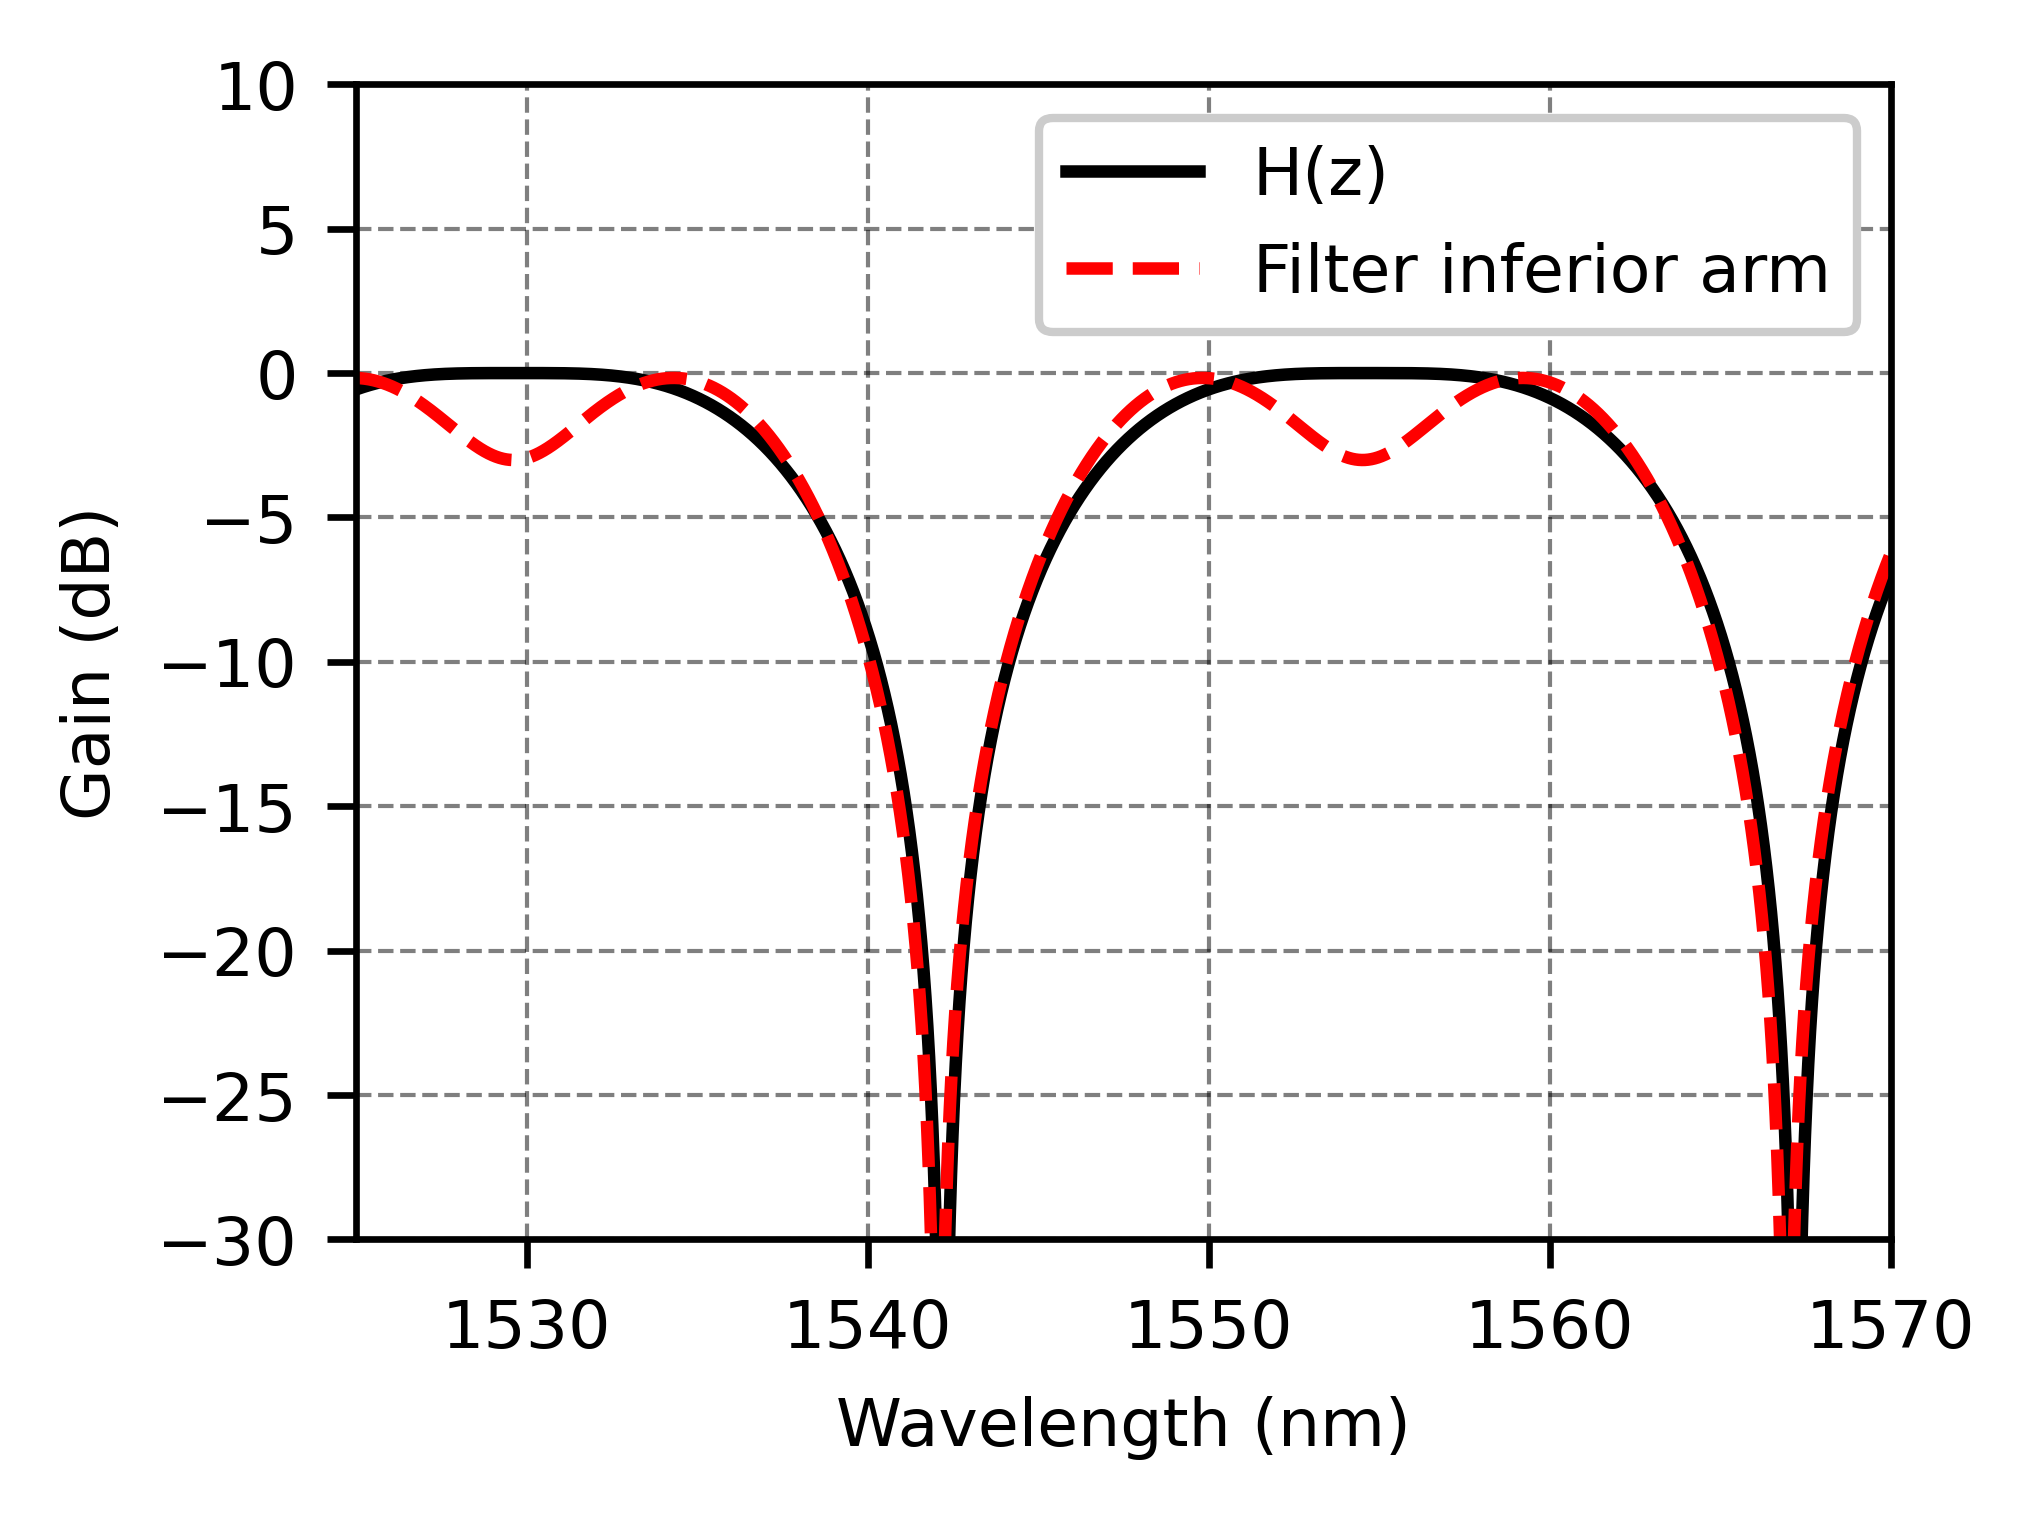

In [23]:
plt.figure();

delay, a1, a2_shifted = find_delay(lower_transmission2, B2_vals)

plt.grid(True)
plt.plot(λ, 10*np.log10(np.roll(B2_vals,delay)), label='H(z)');#, marker='^', markevery=3000, ms=4)
plt.plot(λ, 10*np.log10(lower_transmission2), label='Filter inferior arm');#, marker='o', markevery=3000, ms=3)
plt.ylabel('Gain (dB)');
plt.legend(loc='upper right');
plt.xlabel('Wavelength (nm)');
plt.xlim(cband[0]*1e9,cband[-1]*1e9);
plt.ylim(-30, 10);
plt.xticks();
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# plt.figure();

# delay, a1, a2_shifted = find_delay(upper_transmission2, A2_vals)

# plt.grid(True)
# plt.plot(λ, 10*np.log10(np.roll(A2_vals,delay)), label='G(z)');#, marker='^', markevery=3000, ms=4)
# plt.plot(λ, 10*np.log10(upper_transmission2), label='Superior');#, marker='o', markevery=3000, ms=3)
# plt.ylabel('Gain (dB)');
# plt.legend(loc='upper right');
# plt.xlabel('Wavelength (nm)');
# plt.xlim(cband[0]*1e9,cband[-1]*1e9);
# plt.ylim(-60, 30);
# plt.xticks();
# logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)



# Third Order Test


In [43]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125

desired_order = 2

In [44]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

In [54]:
N_input = 3

#Call the main function to get the paired coefficients
paired_filters = find_filter_pairs(N=N_input, verbose=True, imag_threshold=1e-3, a0_precision=5)
print("\n--- Output Vector of Matched Coefficient Pairs ---")
if not paired_filters:
    print("No matched pairs were found.")
else:
    for i, pair in enumerate(paired_filters):
        print(f"\nPair #{i+1}")
        print(f"G(z) Coeffs (ak): {np.round(pair[0], 5)}")
        print(f"H(z) Coeffs (bk): {np.round(pair[1], 5)}")

--- Generating filters for N=3 and type='maximally_flat' ---

--- Processing A_k to find unique G(z) filters ---
Testing 252 root combinations for A_k...
Found 36 unique G(z) candidates.

--- Processing B_k to find unique H(z) filters ---
Testing 252 root combinations for B_k...
Found 36 unique H(z) candidates.

--- Pairing G(z) and H(z) filters based on closest a0 value ---
Found 36 matched pairs.

--- Output Vector of Matched Coefficient Pairs ---

Pair #1
G(z) Coeffs (ak): [-0.03122 -0.15615 -0.31243 -0.31257 -0.15635 -0.03128]
H(z) Coeffs (bk): [ 0.03122 -0.15615  0.31243 -0.31257  0.15635 -0.03128]

Pair #2
G(z) Coeffs (ak): [-0.03123 -0.1562  -0.31247 -0.31253 -0.1563  -0.03127]
H(z) Coeffs (bk): [ 0.03123 -0.1562   0.31247 -0.31253  0.1563  -0.03127]

Pair #3
G(z) Coeffs (ak): [-0.03123 -0.1562  -0.31247 -0.31253 -0.1563  -0.03127]
H(z) Coeffs (bk): [ 0.03123 -0.1562   0.31247 -0.31253  0.1563  -0.03127]

Pair #4
G(z) Coeffs (ak): [-0.23472 -0.57034 -0.32593  0.0953   0.06066 -0

Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2499π,0.85363,-0.0000
Theta1,-0.4372π,0.59804,-0.0000
Theta0,-0.0461π,0.99476,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


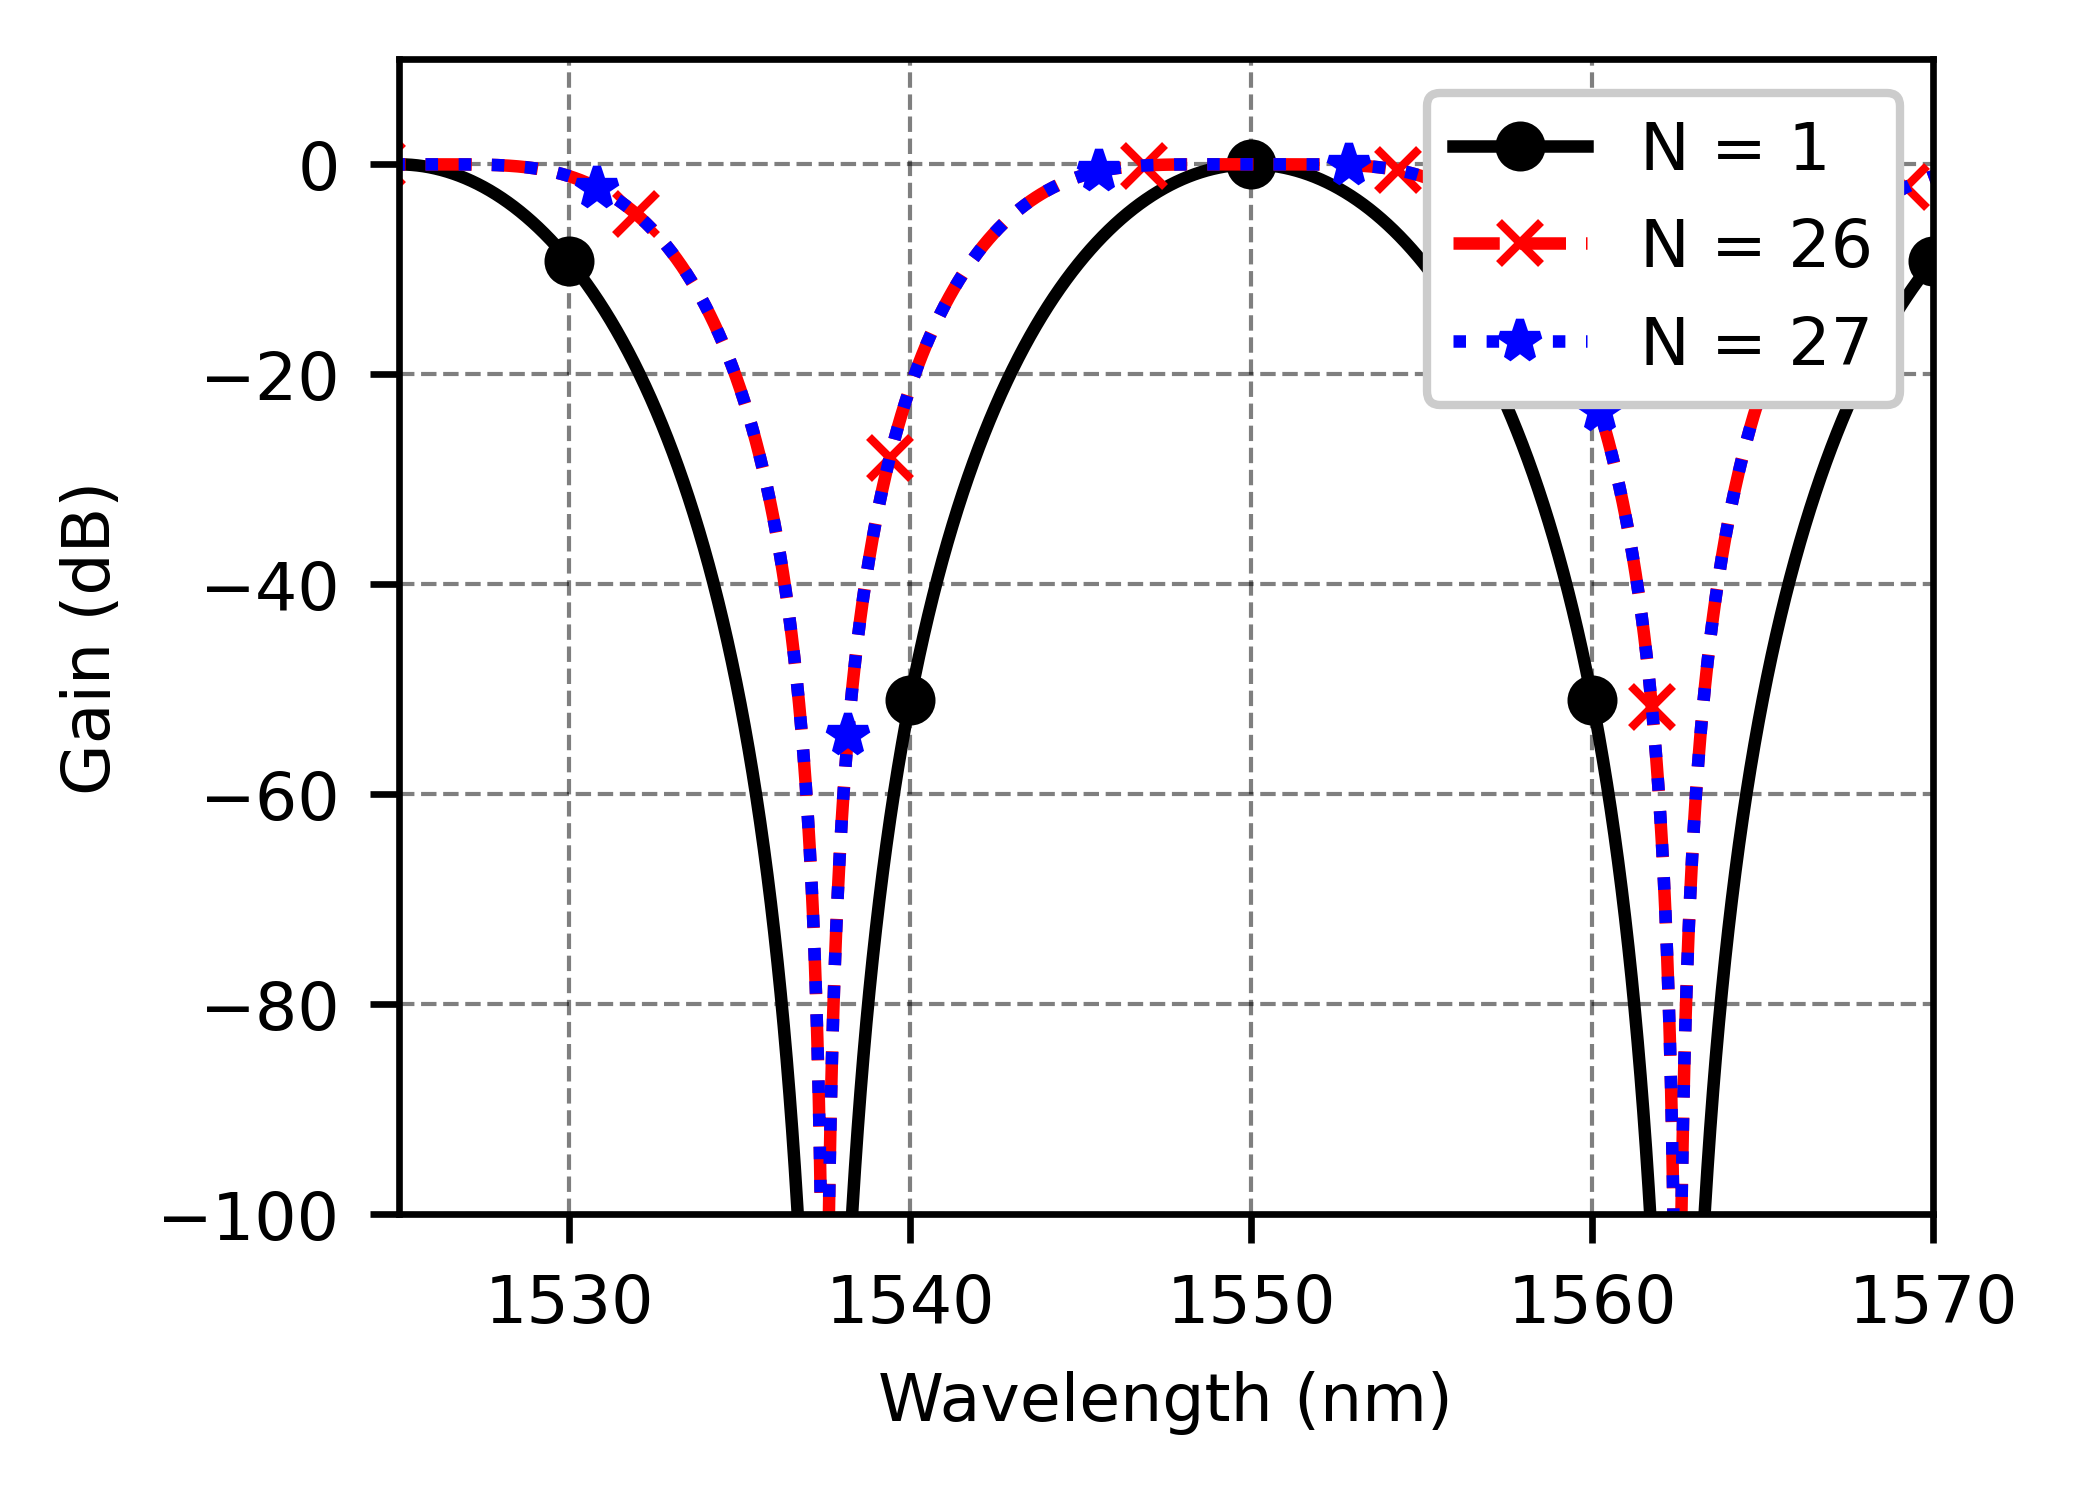

In [57]:
# Regression for G(z) and H(z)

# Can vary N from 0 to len(paired_filters) to change the pair
inapropriate_pairs = []
fig = plt.plot()
deltaL = calculate_delta_L(ng=ng, fsr=25e-9, lambda_0=lambda_0)
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

for i in range(len(paired_filters)):

    pair = [paired_filters[i]]
    
    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    df_results = thetas_phis_df(theta, phi, False)


    Gz_coef = pair[0][0]
    A = sum(coeff * z**(-i) for i, coeff in enumerate(Gz_coef))
    # Transforming Z domain to frequency
    A_freq = A.subs(z, exp(I * ω))
    # Generating numerical function
    A_freq_func = sp.lambdify(ω, A_freq, 'numpy')
    # Obtaining the values for omega_vals
    desired_fsr = 25e-9
    pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
    phase = 0 # allign the value with the desired phase
    omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
    #print(-pi_limits)
    A_vals = np.abs(A_freq_func(omega_vals))
    # Escolha diferentes marcadores para cada iteração
    markers = ['o', '^', 's', 'D', 'v', 'x', '*', 'P', 'h', '+']
    marker = markers[i % len(markers)]
    # Espaçamento dos marcadores (exemplo: a cada 5000 pontos)
    markevery = max(1, len(λ)//20)-i
    if 20*np.log10(A_vals).max() > 0:
        inapropriate_pairs.append(i)
        continue
    else:
        thetas_phis_df(theta, phi, True)
        plt.plot(λ, 20*np.log10(A_vals), label='N = '+str(i+1), marker=marker, markevery=markevery-i*50, ms=5)
    plt.legend(loc='upper right')
    plt.ylabel('Gain (dB)')
    plt.xlabel('Wavelength (nm)')
    plt.xlim(cband[0]*1e9, cband[-1]*1e9)
    plt.ylim(-100, 10)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.show()

31.5935625503595
27.65723989458728
27.65723989458728


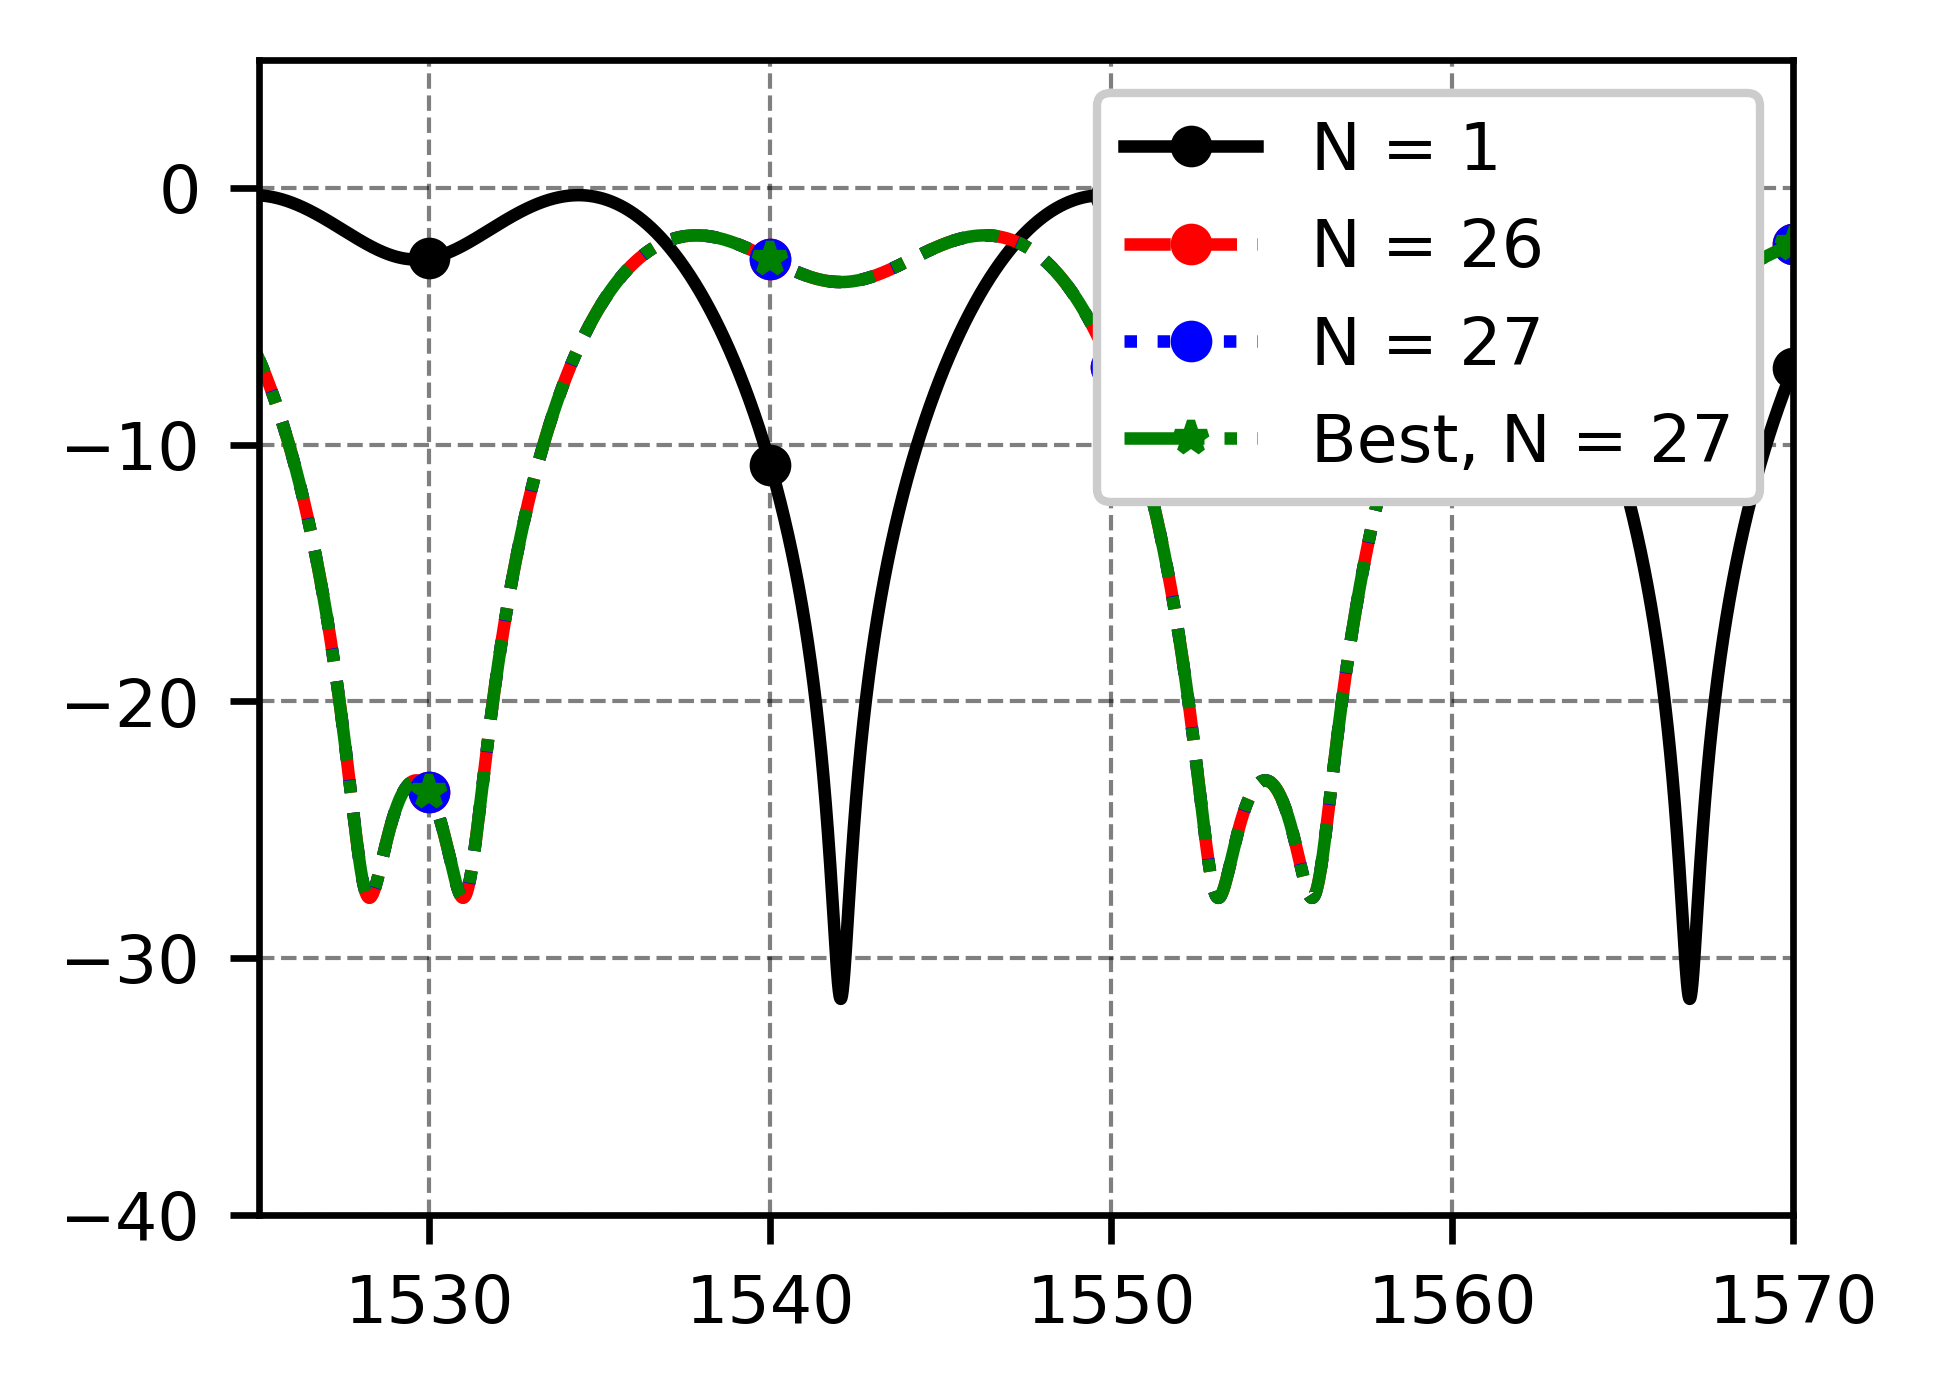

In [ ]:
fig2 = plt.plot()

theta = [0]
phi = [0]


min_upper_val = -np.inf # track the best filter
best_upper_transmission = None # store the spectrum in dB for plotting
N_upper = 0

for i in range(len(paired_filters)):
    pair = [paired_filters[i]]
    if i in inapropriate_pairs:
        continue
    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue

    theta = regression_results[0][0]  # pair's theta
    phi   = regression_results[0][1]  # pair's phi

    df_results = thetas_phis_df(theta, phi, False)

    # skip configurations with any near-zero thetas
    if np.any(np.abs(theta) < 1e-2):
        continue
        
    desired_order = 3
    theta_values_order3 = [theta[3], theta[2], theta[1], theta[0]]
    phi_values_order3   = [phi[2],   phi[1],   phi[0]]

    create_mzi_of_order(
        inter=inter,
        order=desired_order,
        thetas=theta_values_order3,
        phis=phi_values_order3,
        verbose=False
    )
    inter.switchtolayout()
    inter.run()

    upper_transmission3 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmission3 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

    # compute the minimum depth of the lower transmission
    lin = np.asarray(upper_transmission3, dtype=float)
    lin = lin[np.isfinite(lin)]
    if lin.size == 0:
        continue
    depth_db = -10.0 * np.log10(np.clip(lin.min(), 1e-20, None))

    if depth_db > min_upper_val or depth_db > 20:
        min_upper_val = depth_db
        best_upper_transmission = 10.0 * np.log10(np.clip(lin, 1e-20, None))
        N_upper = i + 1
        print(min_upper_val)
        plt.plot(λ, best_upper_transmission, label='N = ' + str(N_upper), marker='o', markevery=5000, ms=4)
        
# pick marker using the chosen index (avoid using 'i' after the loop)
marker = markers[(N_upper - 1) % len(markers)]

if best_upper_transmission is not None:
    plt.plot(λ, best_upper_transmission, label='Best, N = ' + str(N_upper), marker=marker, markevery=5000, ms=4)
    plt.legend(loc='upper right')
    plt.xlim([cband[0]*1e9, cband[-1]*1e9])
    plt.ylim([-40, 5])
else:
    print("No valid best_upper_transmission found to plot.")


Results for pair # 1


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2499π,0.85363,-0.0000
Theta1,-0.4372π,0.59804,-0.0000
Theta0,-0.0461π,0.99476,--------


Results for pair # 2


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2500π,0.85359,-0.0000
Theta1,-0.4372π,0.59805,-0.0000
Theta0,-0.0461π,0.99476,--------


Results for pair # 3


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2500π,0.85359,-0.0000
Theta1,-0.4372π,0.59805,-0.0000
Theta0,-0.0461π,0.99476,--------


Results for pair # 4


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4095π,0.64032,-0.0000
Theta1,-0.1411π,0.95168,-0.0000
Theta0,-0.2449π,0.85920,--------


Results for pair # 6


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2500π,0.85351,-0.0000
Theta1,-0.4372π,0.59807,-0.0000
Theta0,-0.0461π,0.99477,--------


Results for pair # 7


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4093π,0.64059,-0.0000
Theta1,-0.1410π,0.95174,-0.0000
Theta0,-0.2447π,0.85944,--------


Results for pair # 9


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4093π,0.64058,-0.0000
Theta1,-0.1410π,0.95174,-0.0000
Theta0,-0.2447π,0.85944,--------


Results for pair # 11


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


Results for pair # 13


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2500π,0.85351,-0.0000
Theta1,-0.4372π,0.59807,-0.0000
Theta0,-0.0461π,0.99477,--------


Results for pair # 14


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4093π,0.64059,-0.0000
Theta1,-0.1410π,0.95174,-0.0000
Theta0,-0.2447π,0.85944,--------


Results for pair # 16


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


Results for pair # 18


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4091π,0.64085,-0.0000
Theta1,-0.5000π,0.50000,-3.1416
Theta0,-0.4546π,0.57103,--------


Results for pair # 19


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.0909π,0.97975,-0.0000
Theta1,-0.0000π,1.00000,-0.0000
Theta0,-0.0000π,1.00000,--------


Results for pair # 20


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4090π,0.64098,-0.0000
Theta1,-0.1409π,0.95183,-0.0000
Theta0,-0.2443π,0.85979,--------


Results for pair # 22


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4090π,0.64098,-0.0000
Theta1,-0.1409π,0.95183,-0.0000
Theta0,-0.2443π,0.85979,--------


Results for pair # 24


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.2490π,0.85463,0.0000
Theta1,-0.0000π,1.00000,-0.0000
Theta0,-0.3119π,0.77858,--------


Results for pair # 25


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-0.0000
Theta2,-0.2501π,0.85348,-0.0000
Theta1,-0.4372π,0.59808,-0.0000
Theta0,-0.0461π,0.99477,--------


Results for pair # 26


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


Results for pair # 27


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4092π,0.64072,-0.0000
Theta1,-0.1410π,0.95177,-0.0000
Theta0,-0.2445π,0.85956,--------


Results for pair # 28


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4089π,0.64111,-0.0000
Theta1,-0.1408π,0.95186,-0.0000
Theta0,-0.2442π,0.85991,--------


Results for pair # 30


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4089π,0.64111,-0.0000
Theta1,-0.1408π,0.95186,-0.0000
Theta0,-0.2442π,0.85991,--------


Results for pair # 32


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4089π,0.64111,-0.0000
Theta1,-0.1408π,0.95186,-0.0000
Theta0,-0.2442π,0.85991,--------


Results for pair # 34


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4088π,0.64137,-0.0000
Theta1,-0.1407π,0.95191,-0.0000
Theta0,-0.2440π,0.86014,--------


Results for pair # 36


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.2510π,0.85248,-0.0000
Theta1,-0.0000π,1.00000,-0.0000
Theta0,-0.3138π,0.77612,--------


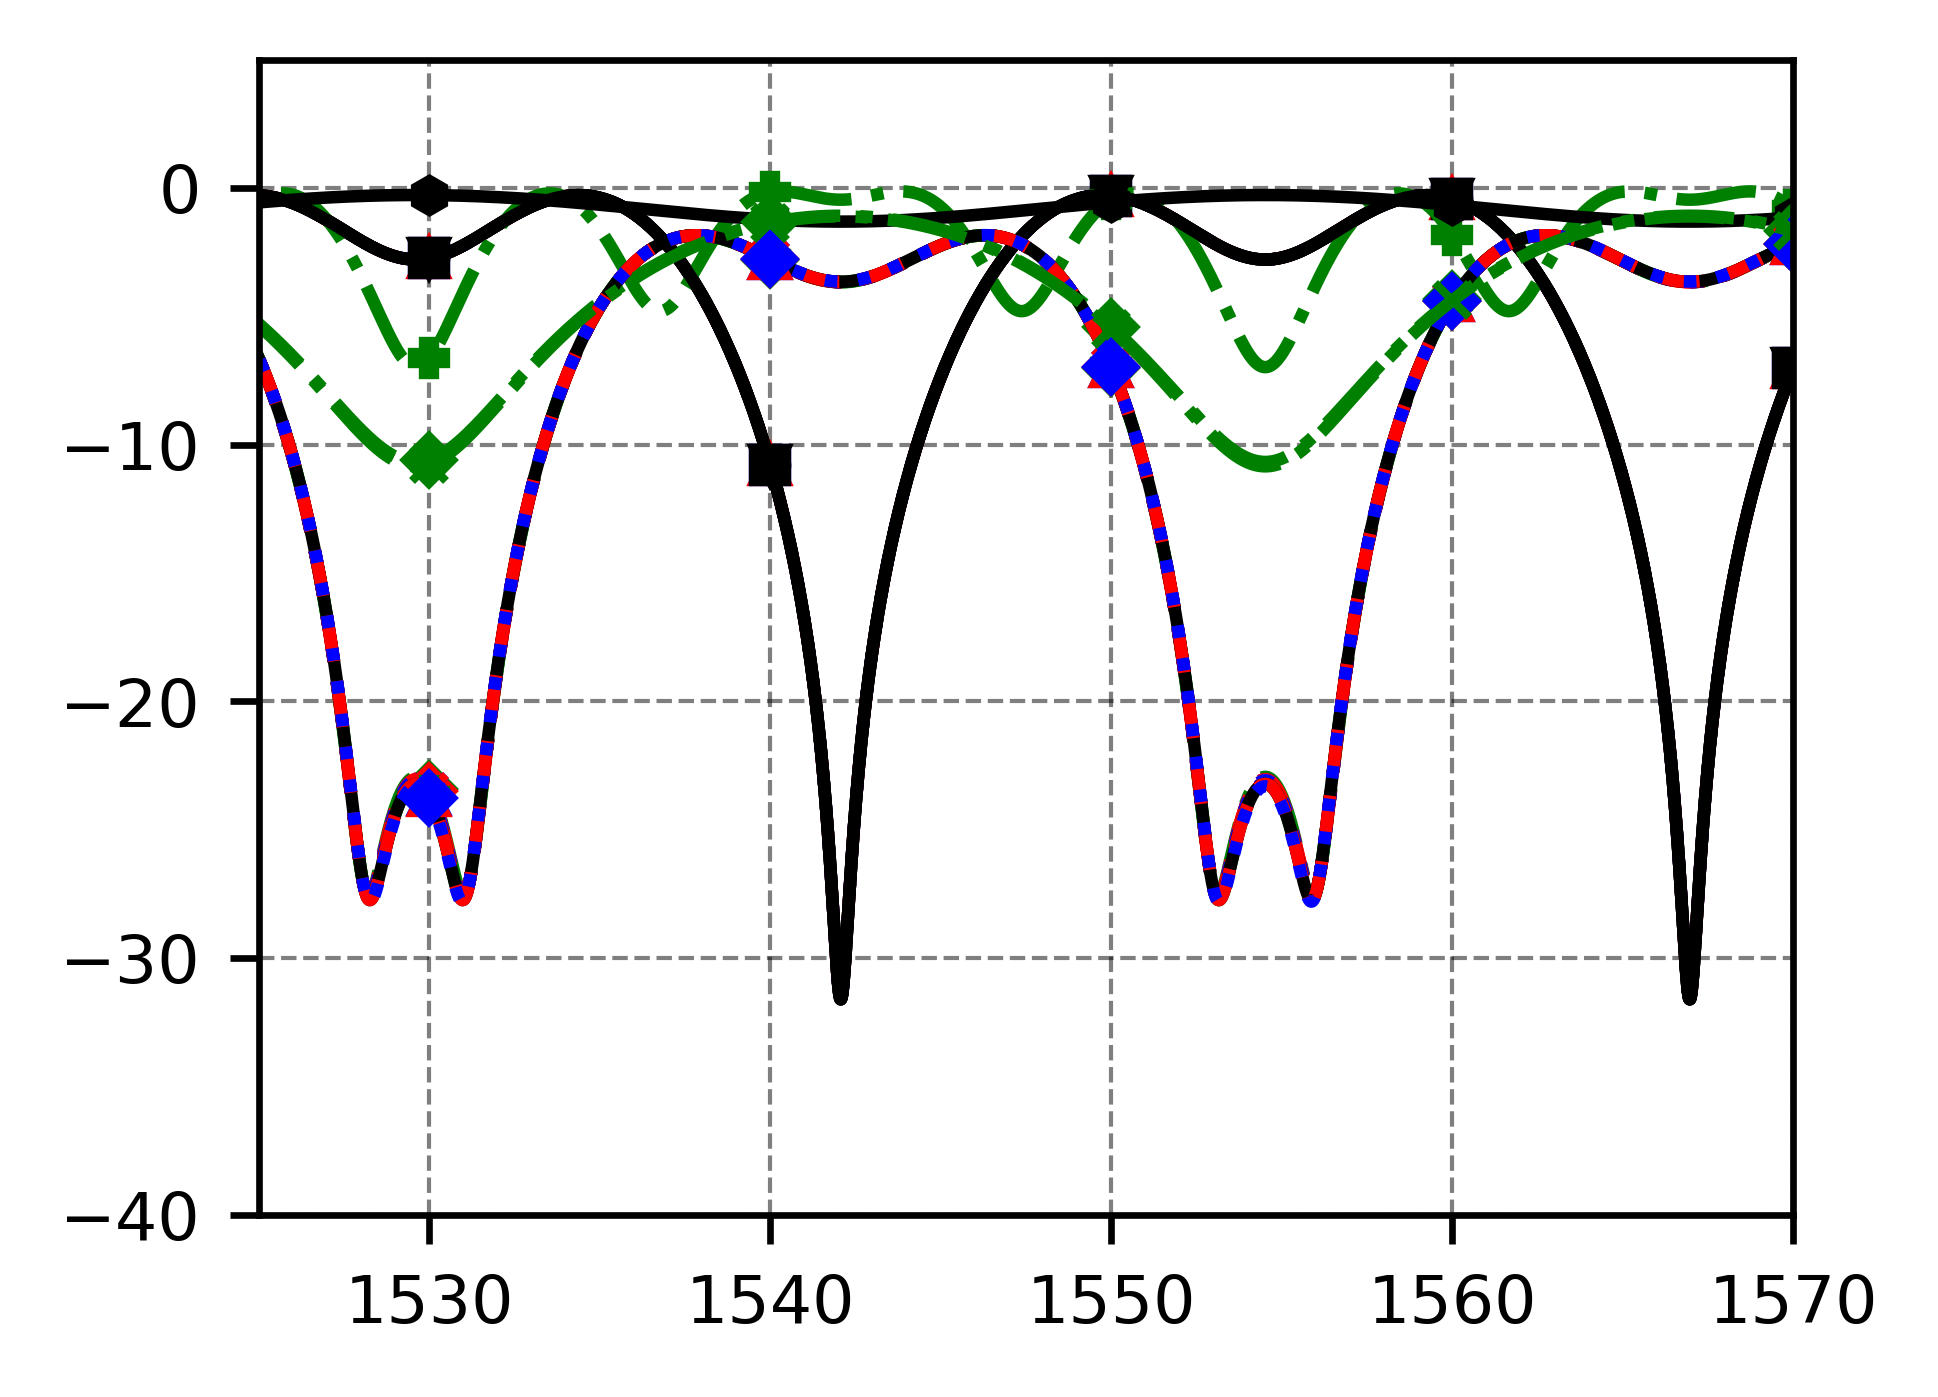

In [59]:
fig3 = plt.plot()
for i in range(len(paired_filters)):
    
    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue

    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    print('Results for pair #',i+1 )    
    df_results = thetas_phis_df(theta, phi, True)


    desired_order = 3
    theta_values_order3 = [theta[3], theta[2], theta[1], theta[0]]
    #print('iteration',i,'Theta = ', theta_values_order3, ' Phi = ', phi)
    phi_values_order3 = [phi[2], phi[1], phi[0]]

    create_mzi_of_order(
        inter=inter, 
        order=desired_order,
        thetas=theta_values_order3,
        phis=phi_values_order3,
        verbose=False
    )
    inter.switchtolayout()
    inter.run()

    upper_transmission3 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmission3 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2    
    marker = markers[i % len(markers)]
    plt.plot(λ, 10*np.log10(upper_transmission3), label='N = '+ str(i+1), marker=marker, markevery=5000, ms=4 )
    #plt.legend(loc='upper right')
    plt.xlim([cband[0]*1e9, cband[-1]*1e9])
    plt.ylim([-40, 5])

In [ ]:
#lumapi = lumapi()
inter = lumapi.INTERCONNECT()

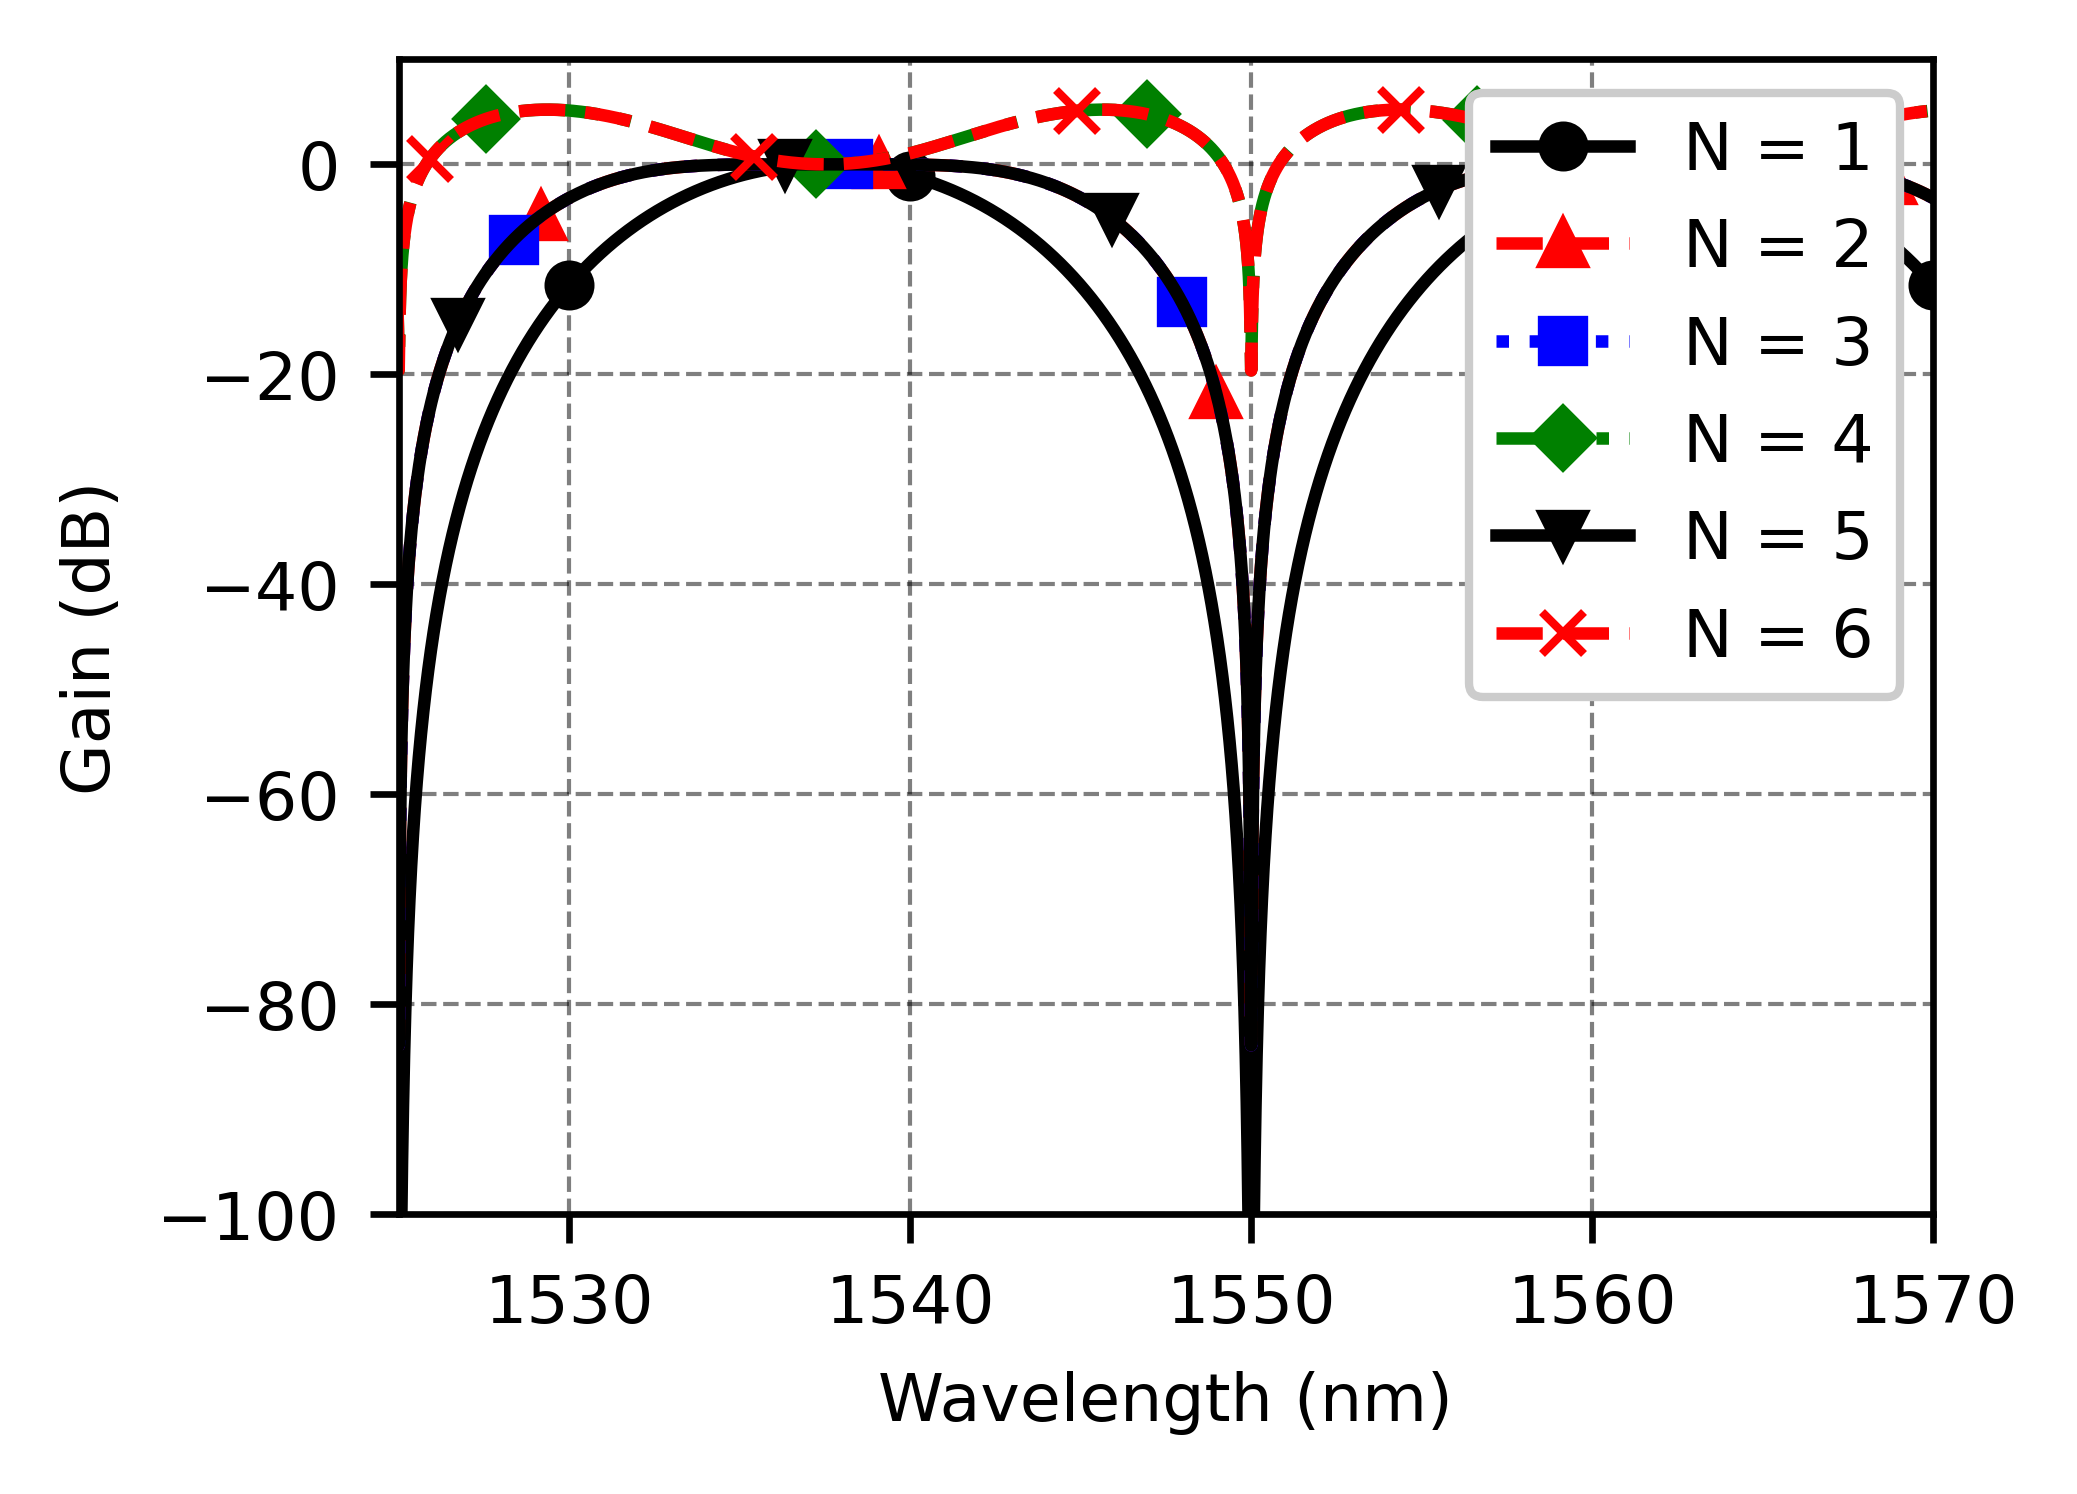

In [ ]:
# Regression for G(z) and H(z)

# Can vary N from 0 to len(paired_filters) to change the pair

fig = plt.plot()
deltaL = calculate_delta_L(ng=ng, fsr=25e-9, lambda_0=lambda_0)
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

for i in range(len(paired_filters)):

    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    df_results = thetas_phis_df(theta, phi, False)


    Hz_coef = pair[0][1]
    B = sum(coeff * z**(-i) for i, coeff in enumerate(Hz_coef))
    # Transforming Z domain to frequency
    B_freq = B.subs(z, exp(I * ω))
    # Generating numerical function
    B_freq_func = sp.lambdify(ω, B_freq, 'numpy')
    # Obtaining the values for omega_vals
    desired_fsr = 25e-9
    pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
    phase = 0 # allign the value with the desired phase
    omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
    #print(-pi_limits)
    B_vals = np.abs(B_freq_func(omega_vals))
    # Escolha diferentes marcadores para cada iteração
    markers = ['o', '^', 's', 'D', 'v', 'x', '*', 'P', 'h', '+']
    marker = markers[i % len(markers)]
    # Espaçamento dos marcadores (exemplo: a cada 5000 pontos)
    markevery = max(1, len(λ)//20)-i
    plt.plot(λ, 10*np.log10(B_vals), label='N = '+str(i+1), marker=marker, markevery=markevery-i*50, ms=5)
    plt.legend(loc='upper right')
    plt.ylabel('Gain (dB)')
    plt.xlabel('Wavelength (nm)')
    plt.xlim(cband[0]*1e9, cband[-1]*1e9)
    plt.ylim(-100, 10)
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.show()



Results for pair # 1


Order,Theta (π),k,Phi
Theta3,-0.2497π,0.85394,-0.0000
Theta2,-0.2500π,0.85355,-3.1416
Theta1,-0.5000π,0.50000,-0.0000
Theta0,-0.0000π,1.00000,--------


Results for pair # 2


Order,Theta (π),k,Phi
Theta3,-0.2495π,0.85413,-3.1416
Theta2,-0.4092π,0.64072,3.1416
Theta1,-0.4985π,0.50232,0.0000
Theta0,-0.4546π,0.57100,--------


Results for pair # 3


Order,Theta (π),k,Phi
Theta3,-0.2493π,0.85432,-0.0000
Theta2,-0.0909π,0.97975,-3.1416
Theta1,-0.0009π,1.00000,-3.1416
Theta0,-0.0097π,0.99977,--------


Results for pair # 4


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.2490π,0.85463,0.0000
Theta1,-0.0000π,1.00000,-0.0000
Theta0,-0.3119π,0.77858,--------


Results for pair # 5


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.4088π,0.64137,-0.0000
Theta1,-0.1407π,0.95191,-0.0000
Theta0,-0.2440π,0.86014,--------


Results for pair # 6


Order,Theta (π),k,Phi
Theta3,-0.2500π,0.85355,-3.1416
Theta2,-0.2510π,0.85248,-0.0000
Theta1,-0.0000π,1.00000,-0.0000
Theta0,-0.3138π,0.77612,--------


(-40.0, 5.0)

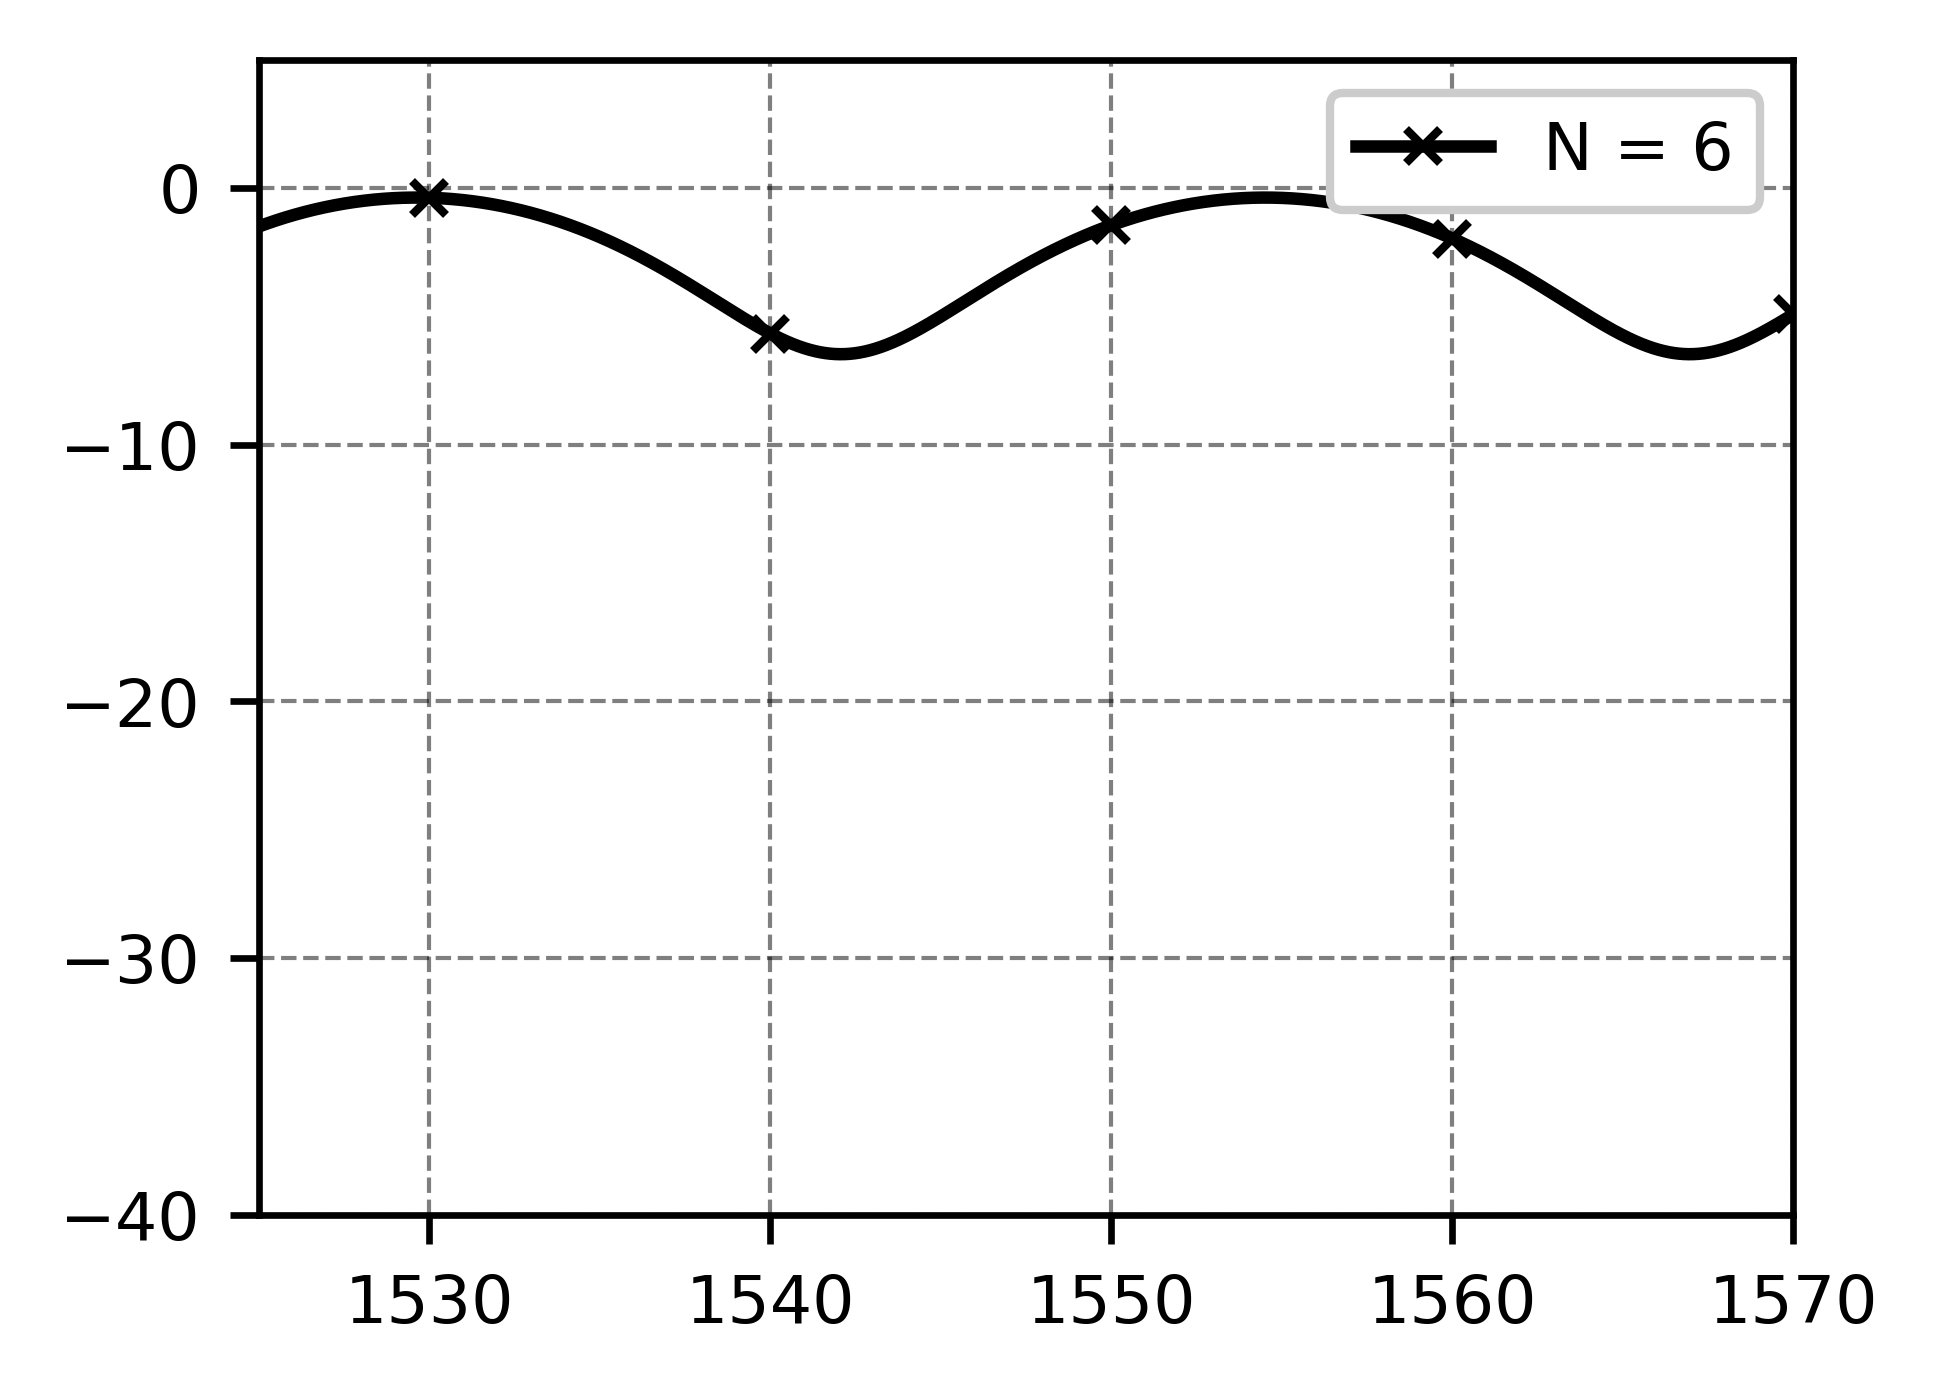

In [ ]:
fig3 = plt.plot()
for i in range(len(paired_filters)):
    
    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(3, pair)  # 3rd order, so N=3
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    print('Results for pair #',i+1 )    
    df_results = thetas_phis_df(theta, phi, True)

    # Definir os parâmetros para um MZI de 3ª ordem
    desired_order = 3

    # Remove configurations with very small theta values
    if np.any(np.abs(theta) < 1e-2):
        continue


theta_values_order3 = [theta[3], theta[2], theta[1], theta[0]]
#print('iteration',i,'Theta = ', theta_values_order3, ' Phi = ', phi)
phi_values_order3 = [phi[2], phi[1], phi[0]]

create_mzi_of_order(
    inter=inter, 
    order=desired_order,
    thetas=theta_values_order3,
    phis=phi_values_order3,
    verbose=False
)
inter.switchtolayout()
inter.run()

upper_transmission3 = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
lower_transmission3 = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2    
marker = markers[i % len(markers)]
plt.plot(λ, 10*np.log10(lower_transmission3), label='N = '+ str(i+1), marker=marker, markevery=5000, ms=4 )
plt.legend(loc='upper right')
plt.xlim([cband[0]*1e9, cband[-1]*1e9])
plt.ylim([-40, 5])

# Fourth Order Test


In [5]:
# Initial definitions 
l = 50e-6
simulationband = [1450e-9, 1650e-9]
lambda_0=1550e-9
cband = [1525e-9, 1570e-9]
ng = 4.2 # Silicon waveguide group index
neff = 2.44
dx = 125

desired_order = 2

In [6]:
if 'inter' not in locals():
    lumapi = lumapi()
    inter = lumapi.INTERCONNECT()

found!
version v202 not found...
version v221 not found...
version v231 not found...
version v241 not found...
version v242 found!
import not found


C:\Program Files\Lumerical\v242\api\python\lumapi.py:895: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [60]:
N = 4

#Call the main function to get the paired coefficients
paired_filters = find_filter_pairs(N=N, verbose=True, imag_threshold=1e-3, a0_precision=5)
print("\n--- Output Vector of Matched Coefficient Pairs ---")
if not paired_filters:
    print("No matched pairs were found.")
else:
    for i, pair in enumerate(paired_filters):
        print(f"\nPair #{i+1}")
        print(f"G(z) Coeffs (ak): {np.round(pair[0], 5)}")
        print(f"H(z) Coeffs (bk): {np.round(pair[1], 5)}")

--- Generating filters for N=4 and type='maximally_flat' ---

--- Processing A_k to find unique G(z) filters ---
Testing 3432 root combinations for A_k...
Found 199 unique G(z) candidates.

--- Processing B_k to find unique H(z) filters ---
Testing 3432 root combinations for B_k...
Found 199 unique H(z) candidates.

--- Pairing G(z) and H(z) filters based on closest a0 value ---
Found 199 matched pairs.

--- Output Vector of Matched Coefficient Pairs ---

Pair #1
G(z) Coeffs (ak): [-0.00776 -0.05444 -0.16362 -0.27319 -0.27368 -0.16451 -0.05494 -0.00786]
H(z) Coeffs (bk): [ 0.00776 -0.00704 -0.02453 -0.04052  0.27654 -0.3986   0.24023 -0.05383]

Pair #2
G(z) Coeffs (ak): [-0.00778 -0.05451 -0.16375 -0.27326 -0.27361 -0.16438 -0.05486 -0.00785]
H(z) Coeffs (bk): [ 0.00778 -0.05451  0.16375 -0.27326  0.27361 -0.16438  0.05486 -0.00785]

Pair #3
G(z) Coeffs (ak): [-0.02303 -0.13111 -0.30235 -0.35119 -0.19735 -0.02544  0.02274  0.00774]
H(z) Coeffs (bk): [ 0.02303 -0.13111  0.30235 -0.35119

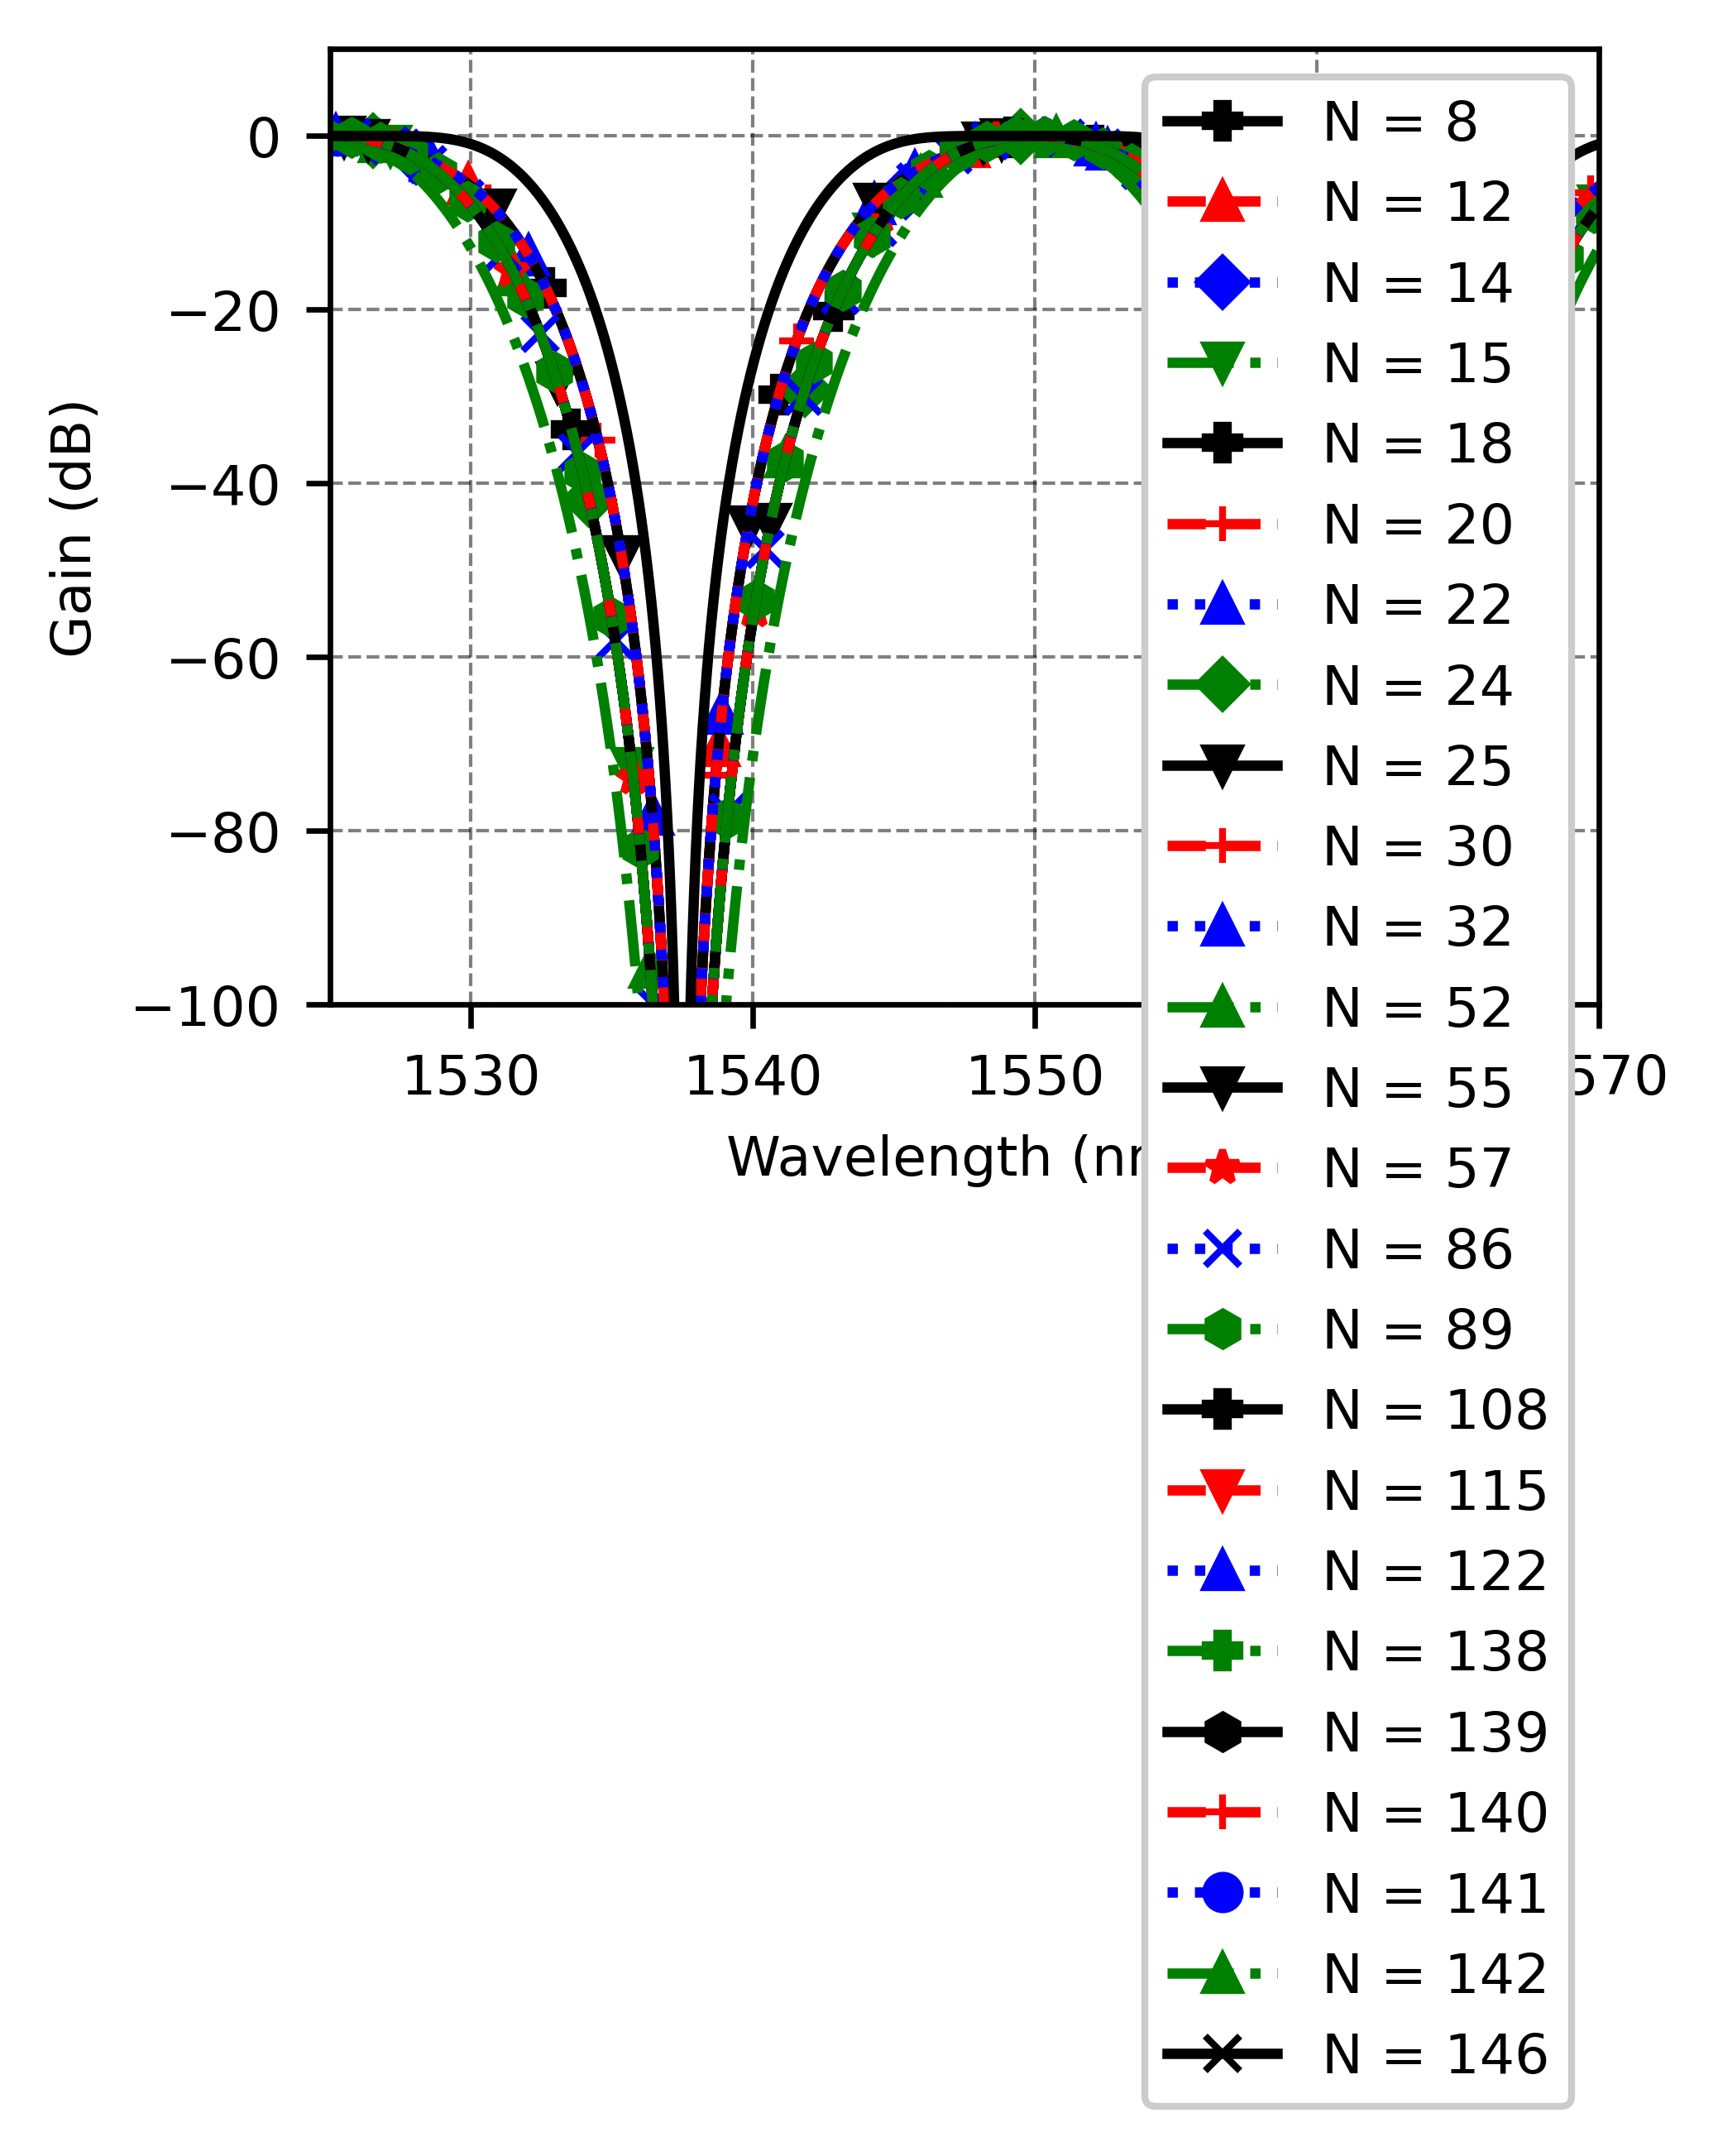

In [61]:
# Regression for G(z) and H(z)

# Can vary N from 0 to len(paired_filters) to change the pair
inapropriate_pairs = []
fig = plt.plot()
deltaL = calculate_delta_L(ng=ng, fsr=25e-9, lambda_0=lambda_0)
# Plotting the results
λ = np.linspace(simulationband[0]*1e9, simulationband[-1]*1e9, points)

for i in range(len(paired_filters)):

    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(N, pair)  # 3rd order, so N=3
    except:
        continue
    theta = regression_results[0][0]  # Get the first pair's theta
    phi = regression_results[0][1]  # Get the first pair's phi
    df_results = thetas_phis_df(theta, phi, False)


    Gz_coef = pair[0][0]
    A = sum(coeff * z**(-i) for i, coeff in enumerate(Gz_coef))
    # Transforming Z domain to frequency
    A_freq = A.subs(z, exp(I * ω))
    # Generating numerical function
    A_freq_func = sp.lambdify(ω, A_freq, 'numpy')
    # Obtaining the values for omega_vals
    desired_fsr = 25e-9
    pi_limits = (simulationband[0]-simulationband[-1])/desired_fsr*π # Calculate the omega span
    phase = 0 # allign the value with the desired phase
    omega_vals = np.linspace(-pi_limits+phase, pi_limits+phase, points) # Setting the omega values for the FSR calculation and optimization
    #print(-pi_limits)
    A_vals = np.abs(A_freq_func(omega_vals))
    # Escolha diferentes marcadores para cada iteração
    markers = ['o', '^', 's', 'D', 'v', 'x', '*', 'P', 'h', '+']
    marker = markers[i % len(markers)]
    # Espaçamento dos marcadores (exemplo: a cada 5000 pontos)
    markevery = max(1, len(λ)//20)-i
    logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
    if 20*np.log10(A_vals).max() > 0:
        inapropriate_pairs.append(i)
        continue
    else:
        plt.plot(λ, 20*np.log10(A_vals), label='N = '+str(i+1), marker=marker, markevery=markevery-i*50, ms=5)
        plt.legend(loc='upper right')
        plt.ylabel('Gain (dB)')
        plt.xlabel('Wavelength (nm)')
        plt.xlim(cband[0]*1e9, cband[-1]*1e9)
        plt.ylim(-100, 10)
plt.show()



In [62]:
print("Inapropriate pairs (G(z) with gain > 0 dB):", len(inapropriate_pairs), "->", inapropriate_pairs)

Inapropriate pairs (G(z) with gain > 0 dB): 151 -> [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 16, 18, 22, 25, 26, 27, 28, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 55, 58, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 110, 111, 112, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 143, 144, 146, 148, 149, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198]


Results for pair # 1
Results for pair # 2
Results for pair # 3
Results for pair # 4
Results for pair # 5
Results for pair # 6
Results for pair # 7
Results for pair # 8
10.100541208287858
Results for pair # 9
Results for pair # 11
Results for pair # 12
Results for pair # 13
Results for pair # 14
Results for pair # 15
12.459837679186347
Results for pair # 16
Results for pair # 17
Results for pair # 18
Results for pair # 19
Results for pair # 20
Results for pair # 22
Results for pair # 23
Results for pair # 24
Results for pair # 25
Results for pair # 26
Results for pair # 27
Results for pair # 28
Results for pair # 29
Results for pair # 30
Results for pair # 32
Results for pair # 33
Results for pair # 34
Results for pair # 35
Results for pair # 36
Results for pair # 37
Results for pair # 39
Results for pair # 40
Results for pair # 42
Results for pair # 43
Results for pair # 44
Results for pair # 45
Results for pair # 46
Results for pair # 47
Results for pair # 48
Results for pair # 49
Res

(-40.0, 5.0)

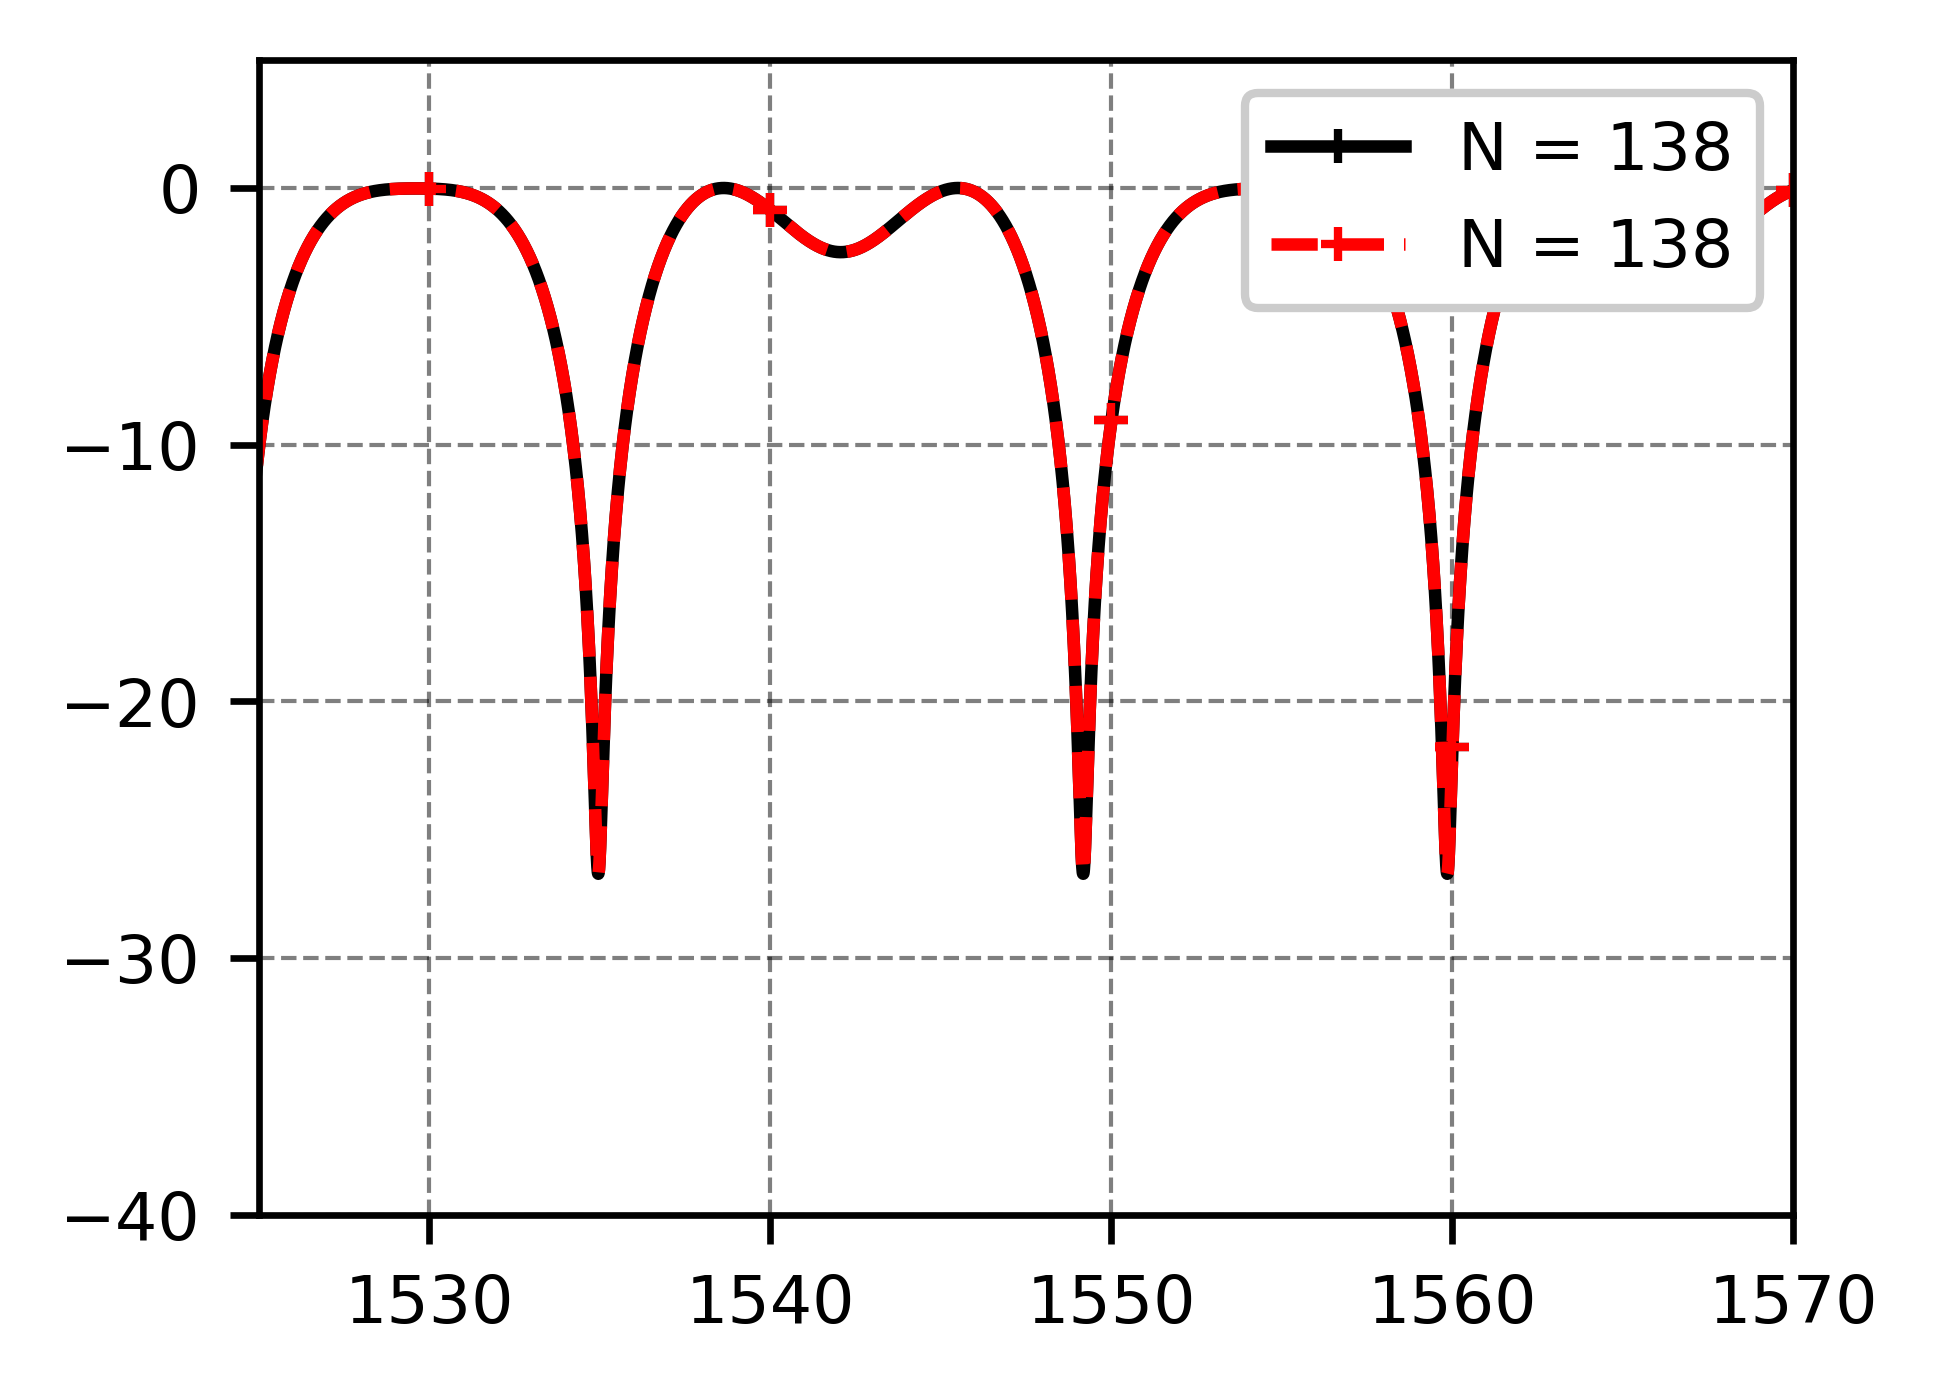

In [65]:
fig2 = plt.plot()

theta = [0]
phi = [0]
N=4

min_upper_val = -np.inf # track the best filter
best_upper_transmission = None # store the spectrum in dB for plotting
N_upper = 0

# Set the desired pair index to execute only that one
#desired_index = 0  # Change to the index of the pair you want to run (0 for the first, 1 for the second, etc.)

for i in range(len(paired_filters)):
    #if i != desired_index:
    #    continue

    pair = [paired_filters[i]]

    try:
        regression_results = regression_for_filter_pairs(N, pair) 
    except:
        continue

    theta = regression_results[0][0]  # pair's theta
    phi   = regression_results[0][1]  # pair's phi

    df_results = thetas_phis_df(theta, phi, False)
    print('Results for pair #', i+1)

    # skip configurations with any near-zero thetas
    if np.any(np.abs(theta) < 1e-2):
        continue

    if i in inapropriate_pairs:
        continue

    desired_order = N
    theta_values_orderN = [theta[4], theta[3], theta[2], theta[1], theta[0]]
    phi_values_orderN = [phi[3], phi[2], phi[1], phi[0]]

    create_mzi_of_order(
        inter=inter,
        order=desired_order,
        thetas=theta_values_orderN,
        phis=phi_values_orderN,
        verbose=False
    )
    try:
        inter.switchtolayout()
        inter.run()
    except:
        continue
    upper_transmissionN = abs(inter.getresult('ONA_1', 'input 1/mode 1/transmission')['TE transmission'])**2
    lower_transmissionN = abs(inter.getresult('ONA_1', 'input 2/mode 1/transmission')['TE transmission'])**2

    # compute the minimum depth of the upper transmission
    lin = np.asarray(upper_transmissionN, dtype=float)
    lin = lin[np.isfinite(lin)]
    if lin.size == 0:
         continue
    depth_db = -10.0 * np.log10(np.clip(lin.min(), 1e-20, None))

    if depth_db > min_upper_val:
         min_upper_val = depth_db
         best_upper_transmission = 10.0 * np.log10(np.clip(lin, 1e-20, None))
         N_upper = i + 1
         print(min_upper_val)
    if depth_db > 18:
        plt.plot(λ, best_upper_transmission, label='N = ' + str(N_upper), marker=marker, markevery=5000, ms=4)

# pick marker using the chosen index (avoid using 'i' after the loop)
marker = markers[(N_upper - 1) % len(markers)]

#plt.plot(λ, best_upper_transmission, label='N = ' + str(N_upper),marker=marker, markevery=5000, ms=4)
plt.legend(loc='upper right')
plt.xlim([cband[0]*1e9, cband[-1]*1e9])
plt.ylim([-40, 5])